In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_columns', None) # to remove limitation of columns visibility

# 1 Context

**Цель**: провести исследовательский анализ данных, обнаружить аномалии и выявить зависимости между данными

**Датасет**: данные о пассажирах корабля Титаник https://www.kaggle.com/c/tabular-playground-series-apr-2021/data (train датасет)

**Описание данных**:

| Variable | Definition | Key |
| :- | :- | :- |
| survival | Survival |	0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |
| Age | Age in years |
| sibsp | # of siblings / spouses aboard the Titanic |
| parch | # of parents / children aboard the Titanic |
| ticket | Ticket number |
| fare | Passenger fare |
| cabin | Cabin number |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

***pclass***: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

***age***: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

***sibsp***: The dataset defines family relations in this way:
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

***parch***: The dataset defines family relations in this way:
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

# 2 Data quality assessment

## 2.1 data loading and overall overview

In [3]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
df.shape

(100000, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


в датасете присутствуют пропуски по Age, Ticket, Fare, Cabin, Embarked

In [6]:
df.duplicated().sum()

0

полностью задублированных строк нет

In [7]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [8]:
df = df.rename(columns={
    'PassengerId': 'passenger_id',
    'Survived': 'survived',
    'Pclass': 'ticket_class',
    'Name': 'passenger_name',
    'Sex': 'sex',
    'Age': 'age',
    'SibSp': 'siblings_spouses_aboard',
    'Parch': 'parents_children_aboard',
    'Ticket': 'ticket_number',
    'Fare': 'fare',
    'Cabin': 'cabin_number',
    'Embarked': 'port_of_embarkation'
})
df.head()

,passenger_id,survived,ticket_class,passenger_name,sex,age,siblings_spouses_aboard,parents_children_aboard,ticket_number,fare,cabin_number,port_of_embarkation
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


переименовали колонки в более говорящие и более "питоновские" по стилю наименования

## 2.2 detailed data profiling

### 2.2.1 passenger_id

In [9]:
df['passenger_id'].nunique()

100000

все id уникальны

### 2.2.2 survived

In [10]:
df['survived'].unique()

array([1, 0], dtype=int64)

In [11]:
df['survived'].value_counts(normalize=True)

0    0.57226
1    0.42774
Name: survived, dtype: float64

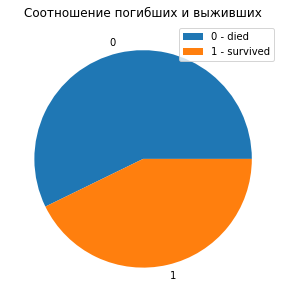

In [12]:
df['survived'].value_counts(normalize=True).plot(kind='pie', legend=True, figsize=(5,5))
plt.title('Соотношение погибших и выживших')
plt.legend(['0 - died', '1 - survived'])
plt.ylabel(None)
plt.show()

по сути это флаг: "выжил"/"не выжил", других начений кроме 1 / 0 нет, доля погибших составляет 57,2%, доля выживших 42,8%

### 2.2.3 ticket_class

In [13]:
df['ticket_class'].value_counts(normalize=True, dropna=False)

3    0.41006
1    0.30315
2    0.28679
Name: ticket_class, dtype: float64

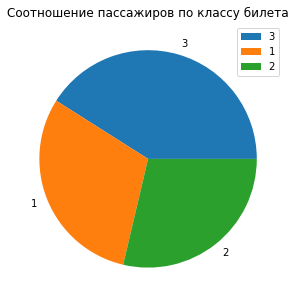

In [14]:
df['ticket_class'].value_counts(normalize=True).plot(kind='pie', legend=True, figsize=(5,5))
plt.title('Соотношение пассажиров по классу билета')
plt.ylabel(None)
plt.show()

аномальных значений нет, пропусков нет, всего три класса 1,2,3, больше всего мест в 3 классе - 41% от общего числа билетов, немного меньше мест 1 класса 30,3% от общего числа, и меньше всего мест во 2 классе - 28,7%

### 2.2.4 passenger_name

In [15]:
df['passenger_name'].nunique()

92144

In [16]:
duplicated_names = (
    df
        .groupby('passenger_name', as_index=False)
            ['passenger_id']
        .count()
        .sort_values(by='passenger_id', ascending=False)
        .query('passenger_id > 1')
        ['passenger_name']
)
duplicated_names

41780         Johnson, John
77252           Smith, John
77218          Smith, James
42033      Johnson, William
77362        Smith, Michael
                ...        
57627         Morgan, Kevin
19131         Dale, Richard
70031    Robertson, William
36108      Henderson, Maria
90269         Wise, William
Name: passenger_name, Length: 4904, dtype: object

In [17]:
rows_with_duplicated_names = df[df['passenger_name'].isin(duplicated_names)].shape[0]
rows_with_duplicated_names

12760

In [18]:
df[df['passenger_name'].isin(duplicated_names)].sort_values(by='passenger_name').head(20)

,passenger_id,survived,ticket_class,passenger_name,sex,age,siblings_spouses_aboard,parents_children_aboard,ticket_number,fare,cabin_number,port_of_embarkation
83433,83433,0,1,"Abbott, Steven",male,62.0,1,1,C.A. 415184,81.79,A15776,S
43514,43514,0,3,"Abbott, Steven",male,39.0,0,0,44125,23.38,NaN,S
11074,11074,0,3,"Acevedo, James",male,51.0,0,0,NaN,29.08,NaN,S
40840,40840,0,1,"Acevedo, James",male,NaN,0,0,420535,102.87,A10333,S
39910,39910,0,3,"Acosta, David",male,23.0,0,0,30739,12.56,NaN,S
47172,47172,0,1,"Acosta, David",male,40.0,0,0,444308,90.82,B21005,Q
2441,2441,0,3,"Adams, Andres",male,38.0,0,0,9234,7.32,NaN,S
9649,9649,0,1,"Adams, Andres",male,39.0,1,0,204626,13.06,NaN,Q
65557,65557,0,3,"Adams, Anthony",male,52.0,0,0,SC/AH 4156058,7.09,NaN,S
12843,12843,0,2,"Adams, Anthony",male,8.0,0,0,CA. 44794,9.39,NaN,S


датасет синтетический, но все же дубликаты в именах выглядят странно, но тем не менее по другим полям эти строки отличаются в том числе, конечно по passenger_id

In [19]:
(
    df[df['passenger_name'].isin(duplicated_names)]
        .groupby(['cabin_number', 'ticket_number'], as_index=False)
            ['passenger_id'].count()
        .sort_values(by=['cabin_number', 'ticket_number', 'passenger_id'],
                    ascending=[True, True, False])
        .head(50)
)

,cabin_number,ticket_number,passenger_id
0,A10044,PC 30070,1
1,A10057,19081,1
2,A10085,26037,1
3,A10104,49062,1
4,A10137,SOTON/OQ 417881,1
5,A10176,10795,1
6,A10186,PC 364306,1
7,A10208,315636,1
8,A10256,25845,1
9,A10260,455027,1


тем не менее у однофамильцев и тесок оказались разные номера кают и билетов, кроме того, у них уникальные passenger_id, будем считать, что мир синтетического датасета тесен, и все имена уникальны

### 2.2.5 sex

In [20]:
df['sex'].unique()

array(['male', 'female'], dtype=object)

In [21]:
df['sex'].value_counts(normalize=True)

male      0.56114
female    0.43886
Name: sex, dtype: float64

среди пассажиров больше было мужчин - 56,1% против 43,9% женщин

обозначим через 0 (male) / 1 (female), чтобы учитывать этот признак при корреляции

In [22]:
df['sex'] = df['sex'].apply(lambda x: 0 if x == 'male' else 1 if x == 'female' else np.nan)
df['sex'].value_counts(normalize=True)

0    0.56114
1    0.43886
Name: sex, dtype: float64

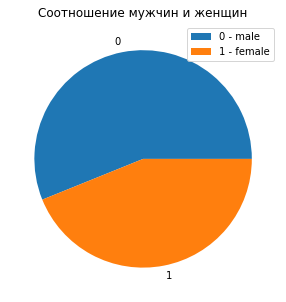

In [23]:
df['sex'].value_counts(normalize=True).plot(kind='pie', legend=True, figsize=(5,5))
plt.title('Соотношение мужчин и женщин')
plt.legend(['0 - male', '1 - female'])
plt.ylabel(None)
plt.show()

### 2.2.6 age

In [24]:
df['age'].sort_values()

35773    0.08
84842    0.08
48045    0.08
35654    0.08
35328    0.08
         ... 
99772     NaN
99876     NaN
99971     NaN
99972     NaN
99986     NaN
Name: age, Length: 100000, dtype: float64

In [25]:
df['age'].isna().mean()

0.03292

по колонке возраста присутствуют пропуски, они составляют 3,29% от общего датасета (100 тыс. строк), что в целом пожалуй, не так страшно

In [26]:
pd.DataFrame(df['age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
age,96708.0,38.355472,18.313556,0.08,25.0,39.0,53.0,87.0


заменим пропущенные значения медианой

In [27]:
age_median = df['age'].median()
df['age'] = df['age'].fillna(age_median)
pd.DataFrame(df['age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,38.37669,18.009956,0.08,25.0,39.0,53.0,87.0


в результате замены пустых значений среднее практически не изменилось, как и стандартное отклонение, квартили остались прежними

в целом дробная часть в возрасте не очень удобна для анализа, преобразуем в целое значение, по традиции, год считается, когда он завершен, т.е. если ребенку 1 мес., то ему 0 лет, только по истечении 12 мес. это будет год, поэтому округлим до целого вниз

In [28]:
df['full_age'] = df['age'].apply(lambda x: math.floor(x))
df['full_age'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87], dtype=int64)

In [29]:
df.groupby('full_age', as_index=False)['passenger_id'].count().head(20)

,full_age,passenger_id
0,0,642
1,1,651
2,2,886
3,3,927
4,4,1017
5,5,1013
6,6,974
7,7,947
8,8,819
9,9,735


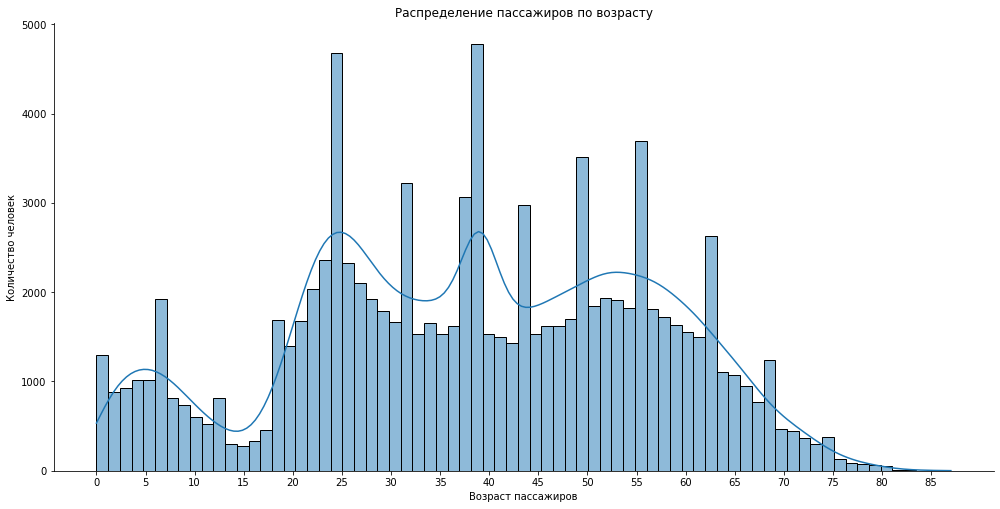

In [30]:
sns.displot(x=df['full_age'], height=7, aspect=2, kde=True)
plt.title('Распределение пассажиров по возрасту')
plt.xlabel('Возраст пассажиров')
plt.ylabel('Количество человек')
plt.xticks(np.arange(0, df['full_age'].max(), 5))
plt.show()

распределение в целом выглядит вполне реальным, можно сказать, что присутствовало достаточно большое количество детей в возрасте до 10 лет (что интересно, есть и совсем младенцы, возраст которых примерно равен 1 мес.=0,08 от года), немного меньше подростков  в рзрасте до 17 лет, основная часть пассажиров находилась в возрасте 20-30 лет, далее примерно одинаковое распределение людей по годам в возрасте от 30 до 50, достаточно много людей в возрасте 50-60 лет, затем количество людей по годам начинает постепенно убывать, максимальный возраст пассажира был равен 87 лет

что интересно, есть отдельные "выбросы", несмотря на естественное природное равномерное распределение людей по годам, конкретно на Титанике по каким-то причинам было необычно много детей именно в возрасте 6 лет, людей в возрасте 24, 29, 34, 39 (конкретно это значение из-за заполнения пропусков), 41, 46, 53, 59, 64, 69 лет, возможно из-за того, что датасет синтетический или так неравномерно сделали деление на train/test

In [31]:
pd.DataFrame(df['age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
age,100000.0,38.37669,18.009956,0.08,25.0,39.0,53.0,87.0


средний возраст пассажира составляет 38 лет, но это скорее некая техническая средняя величина, потому что на борту есть как маленькие дети, так и достаточно пожилые люди, и при этом стандартное отклонение составляет практически 18 лет, что и говорит о большом разбросе значений и представленности самых разных возрастов, и это подтверждается графиком выше

в целом возраст может быть интересно побить на группы по 5 лет, анализировать данные в разрезе групп может быть удобнее, чем по всем 87 годам

In [32]:
df['age_group'] = df['full_age'].apply(lambda x: f'{int(x // 10 * 10)} - {int(x // 10 * 10 + 4)}' if x % 10 < 5 else \
                                                  f'{int(x // 10 * 10 + 5)} - {int(x // 10 * 10 + 9)}' if x % 10 >= 5 else \
                                                  'check the logic')
df['age_group'].sort_values().unique()

array(['0 - 4', '10 - 14', '15 - 19', '20 - 24', '25 - 29', '30 - 34',
       '35 - 39', '40 - 44', '45 - 49', '5 - 9', '50 - 54', '55 - 59',
       '60 - 64', '65 - 69', '70 - 74', '75 - 79', '80 - 84', '85 - 89'],
      dtype=object)

In [33]:
df.groupby(['age_group', 'full_age'], as_index=False)['passenger_id'].count().sort_values(by='full_age').head(25)

,age_group,full_age,passenger_id
0,0 - 4,0,642
1,0 - 4,1,651
2,0 - 4,2,886
3,0 - 4,3,927
4,0 - 4,4,1017
45,5 - 9,5,1013
46,5 - 9,6,974
47,5 - 9,7,947
48,5 - 9,8,819
49,5 - 9,9,735


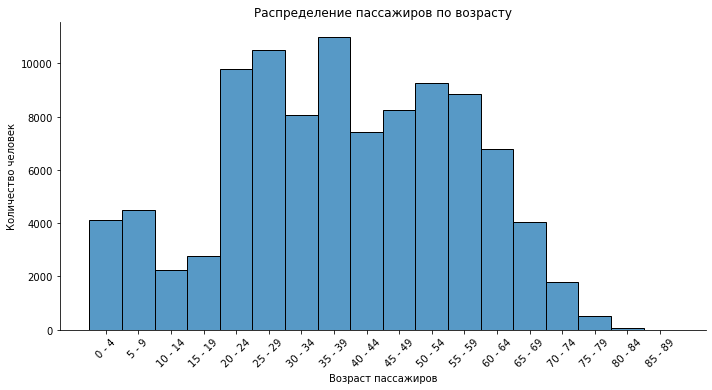

In [34]:
sns.displot(x=df.sort_values(by='full_age')['age_group'], height=5, aspect=2)
plt.title('Распределение пассажиров по возрасту')
plt.xlabel('Возраст пассажиров')
plt.ylabel('Количество человек')
plt.xticks(rotation=45)
plt.show()

группы разбиты успешно, распределение сохранилось и теперь его легче читать

In [35]:
age_groups = df.sort_values(by='full_age')['age_group'].dropna().unique()
age_group_df = pd.DataFrame({
    'age_group_id': [i for i in range(1, len(age_groups) + 1)],
    'age_group': age_groups
})
print('Mapping table for cabin type:')
display(age_group_df)

df['age_group_id'] = 0
for a_group in age_groups:
    age_group_id = age_group_df.query('age_group == @a_group')['age_group_id'].item()
    df.loc[df['age_group']==a_group, 'age_group_id'] = age_group_id
print('Check result of mapping:')
display(
    df
        .groupby(['age_group', 'age_group_id'], as_index=False, dropna=False)
            ['passenger_id']
        .count()
        .sort_values(by='age_group_id')
)

Mapping table for cabin type:


,age_group_id,age_group
0,1,0 - 4
1,2,5 - 9
2,3,10 - 14
3,4,15 - 19
4,5,20 - 24
5,6,25 - 29
6,7,30 - 34
7,8,35 - 39
8,9,40 - 44
9,10,45 - 49


Check result of mapping:


,age_group,age_group_id,passenger_id
0,0 - 4,1,4123
9,5 - 9,2,4488
1,10 - 14,3,2241
2,15 - 19,4,2758
3,20 - 24,5,9775
4,25 - 29,6,10508
5,30 - 34,7,8080
6,35 - 39,8,10995
7,40 - 44,9,7436
8,45 - 49,10,8241


### 2.2.7 siblings_spouses_aboard

In [36]:
df['siblings_spouses_aboard'].value_counts().reset_index().sort_values(by='index')

,index,siblings_spouses_aboard
0,0,73308
1,1,19758
2,2,3703
3,3,1635
4,4,1168
6,5,132
5,8,296


In [37]:
df['siblings_spouses_aboard'].value_counts(normalize=True).reset_index().sort_values(by='index')

,index,siblings_spouses_aboard
0,0,0.73308
1,1,0.19758
2,2,0.03703
3,3,0.01635
4,4,0.01168
6,5,0.00132
5,8,0.00296


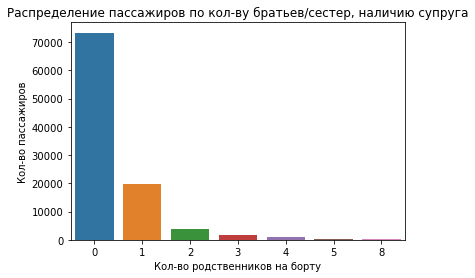

In [38]:
sns.countplot(x=df['siblings_spouses_aboard'])
plt.title('Распределение пассажиров по кол-ву братьев/сестер, наличию супруга')
plt.xlabel('Кол-во родственников на борту')
plt.ylabel('Кол-во пассажиров')
plt.show()

подавляющее большинство пассажиров путешествуют в одиночку, либо же имеют одного (брата/сестру/супруга)

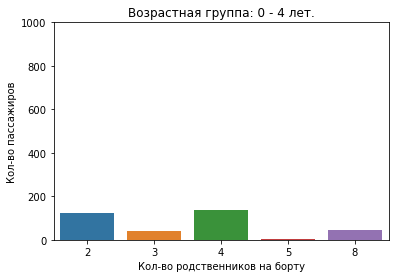

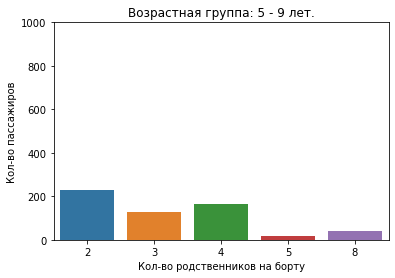

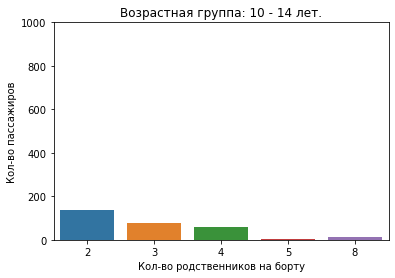

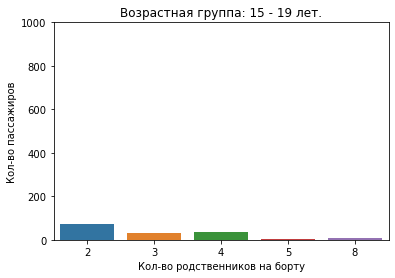

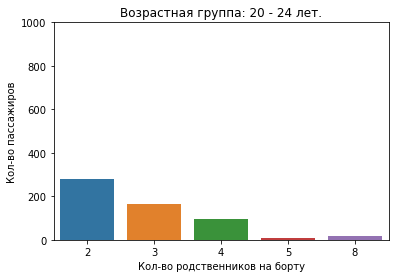

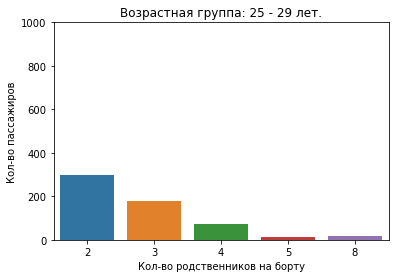

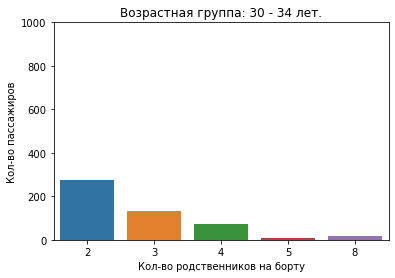

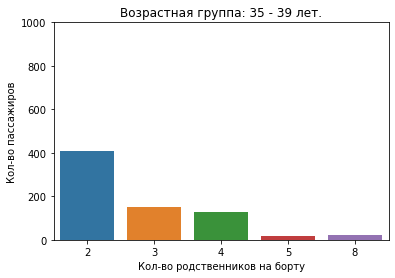

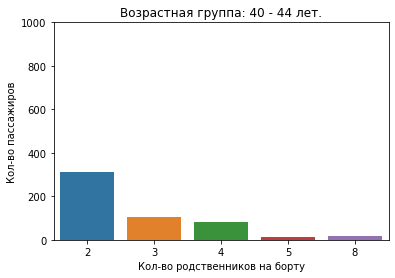

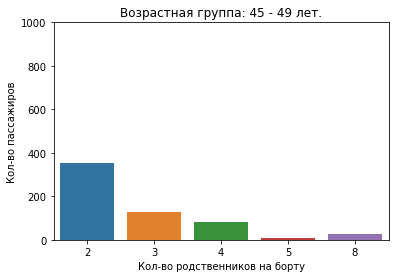

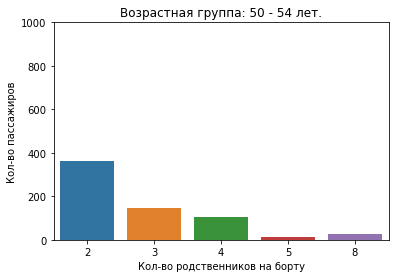

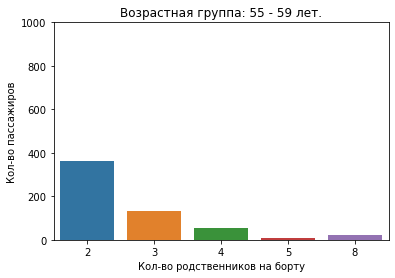

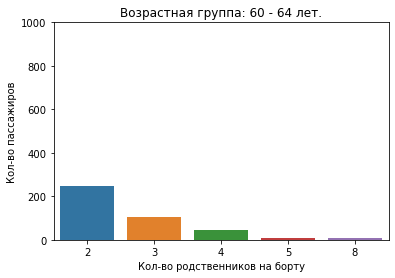

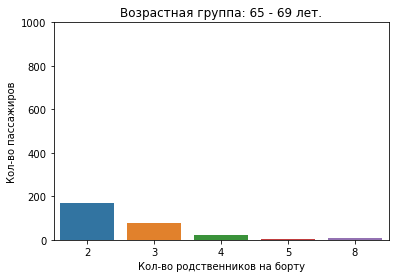

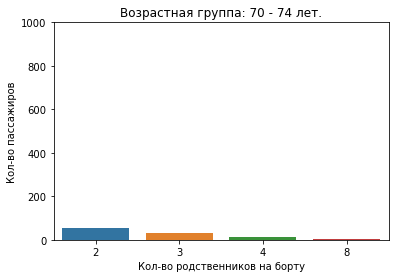

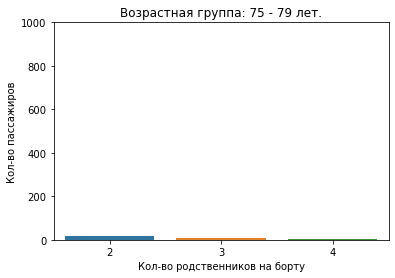

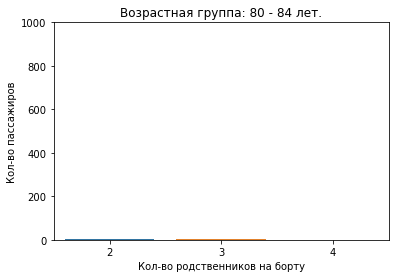

In [39]:
age_groups = df.sort_values(by='full_age')['age_group'].unique()
for group in age_groups:
    group_data = (
        df
            .query('siblings_spouses_aboard > 1 and age_group == @group')
                ['siblings_spouses_aboard']
    )
    if len(group_data) > 0:
        sns.countplot(x=group_data)
        plt.title(f'Возрастная группа: {group} лет.')
        plt.xlabel('Кол-во родственников на борту')
        plt.ylabel('Кол-во пассажиров')
        plt.ylim((0,1000))
        plt.show()

что и логично, зачастую если есть 2 и более sibling_spouses, то чаще всего это семьи семьи с детьми (которые соответсвенно друг другу брат-сестра, потому что супруг/супруга может быть только 1), т.е. на корабле люди путешествовали большими семьями, в целом доля пассажиров с siblings_spouses > 1 составляет примерно 6.9% от общего числа пассажиров, 19,8% составляют пары либо брат+сестра и 73,3% люди, путешествующие в одиночку

### 2.2.8 parents_children_aboard

In [40]:
df['parents_children_aboard'].unique()

array([0, 2, 1, 4, 3, 5, 6, 9], dtype=int64)

максимальное число родителей/детей согласуется с предыдщим показателем братьев/сестер/супругов, т.к. если у человека 8 братьев/сестер, то в семье 9 детей

In [41]:
df['parents_children_aboard'].value_counts().reset_index().sort_values(by='index')

,index,parents_children_aboard
0,0,73540
1,1,12996
2,2,11236
3,3,983
4,4,446
5,5,331
7,6,204
6,9,264


In [42]:
df['parents_children_aboard'].value_counts(normalize=True).reset_index().sort_values(by='index')

,index,parents_children_aboard
0,0,0.73540
1,1,0.12996
2,2,0.11236
3,3,0.00983
4,4,0.00446
5,5,0.00331
7,6,0.00204
6,9,0.00264


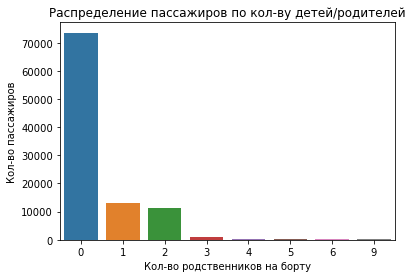

In [43]:
sns.countplot(x=df['parents_children_aboard'])
plt.title('Распределение пассажиров по кол-ву детей/родителей')
plt.xlabel('Кол-во родственников на борту')
plt.ylabel('Кол-во пассажиров')
plt.show()

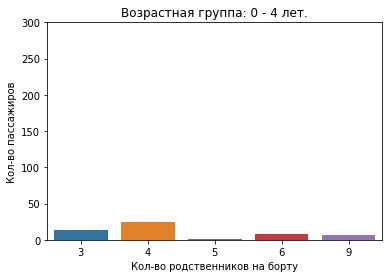

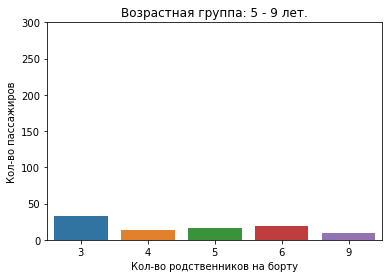

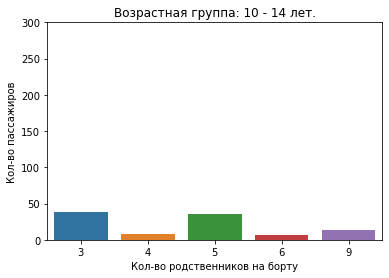

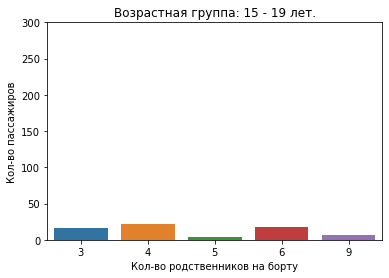

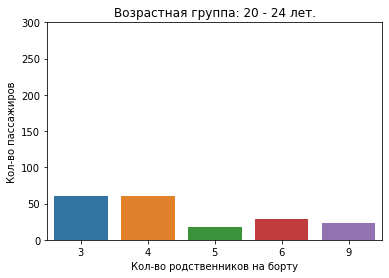

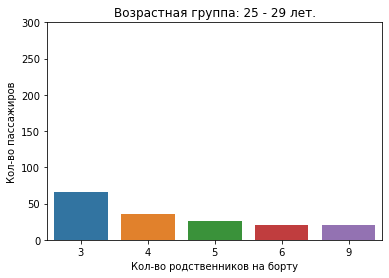

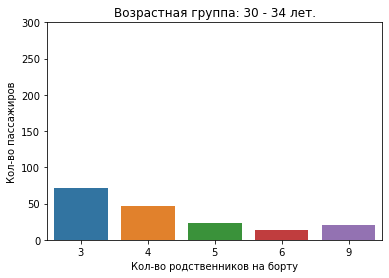

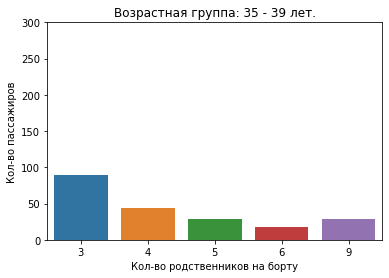

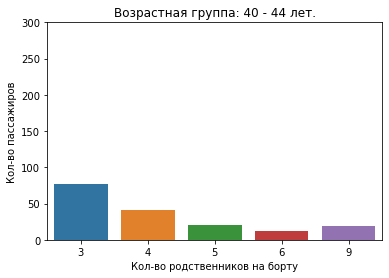

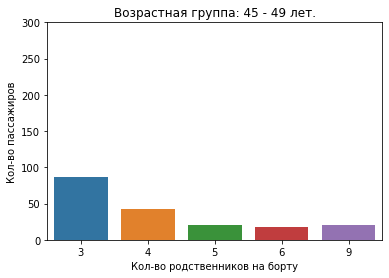

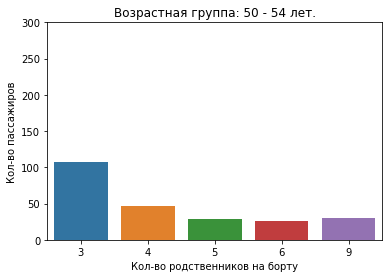

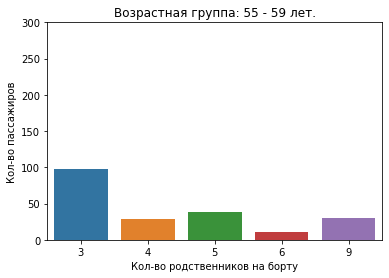

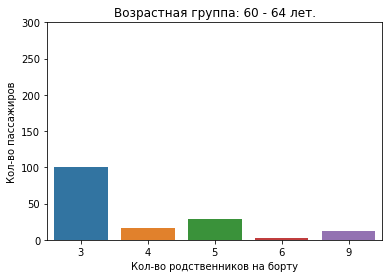

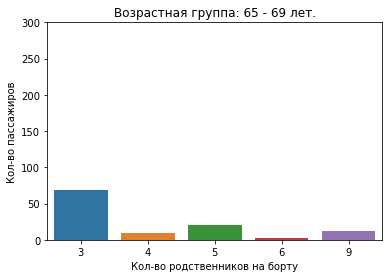

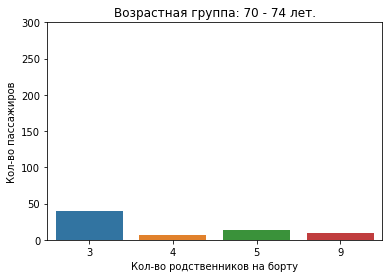

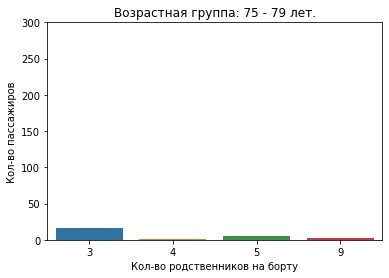

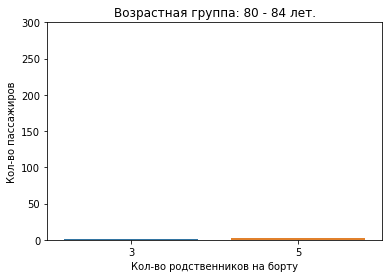

In [44]:
age_groups = df.sort_values(by='full_age')['age_group'].unique()
for group in age_groups:
    group_data = (
        df
            .query('parents_children_aboard > 2 and age_group == @group')
                ['parents_children_aboard']
    )
    if len(group_data) > 0:
        sns.countplot(x=group_data)
        plt.title(f'Возрастная группа: {group} лет.')
        plt.xlabel('Кол-во родственников на борту')
        plt.ylabel('Кол-во пассажиров')
        plt.ylim((0,300))
        plt.show()

на самом деле очень интересно, можно предположить, что в основном это были молодые семьи с детьми, но в то же время есть достаточно много возрастных пассажиров с детьми, можно попробовать предположить, что могли путешествовать с бабушками, дедушками целые поколения либо более взрослые пассажиры с уже более взрослыми детьми

### 2.2.9 ticket_number

In [45]:
df['ticket_number'].isna().mean()

0.04623

In [46]:
df['ticket_number'].sample(20)

49971         A. 504181
86772    STON/O 3882717
59394            207420
73640            364610
82526             21628
83879            391011
66455         CA. 25587
82540               NaN
67357            483863
47037     STON/O 228871
86870            223684
93789             21826
54814             12144
1501           PC 30926
10238             23694
28837            443648
81891             42378
72899            210088
70616          PC 25659
20565             11634
Name: ticket_number, dtype: object

примерно 4,6% значений отсутствуют, наверное намым безобидным будет заменить на 'unknown'

In [47]:
df['ticket_number'] = df['ticket_number'].fillna('unknown')
df['ticket_number'].isna().sum()

0

In [48]:
df['ticket_number'].count()

100000

In [49]:
df['ticket_number'].nunique()

75332

In [50]:
duplicated_tickets = df[df['ticket_number'].duplicated()]['ticket_number'].sort_values().unique()
duplicated_tickets

array(['10002', '10003', '10005', ..., 'W./C. ', 'W.E.P. ', 'unknown'],
      dtype=object)

In [51]:
(
    df
        .query('ticket_number in @duplicated_tickets \
                and ticket_number != "unknown"')
        .sort_values(by=['ticket_number', 'cabin_number'])
        .head(20)
)

,passenger_id,survived,ticket_class,passenger_name,sex,age,siblings_spouses_aboard,parents_children_aboard,ticket_number,fare,cabin_number,port_of_embarkation,full_age,age_group,age_group_id
46097,46097,0,1,"Mccoy, Stephen",0,30.0,1,0,10002,73.00,E15016,S,30,30 - 34,7
61798,61798,1,3,"Thompson, Carole",1,67.0,4,1,10002,33.10,NaN,C,67,65 - 69,14
73205,73205,0,1,"Reiser, Dennis",0,67.0,0,0,10003,22.02,C18944,S,67,65 - 69,14
24266,24266,1,1,"Strutz, Crista",1,31.0,0,0,10003,34.97,C18956,C,31,30 - 34,7
18640,18640,1,3,"Sampson, Calvin",0,7.0,1,2,10003,38.17,NaN,C,7,5 - 9,2
61118,61118,0,2,"Day, Trinidad",1,21.0,0,0,10003,4.87,NaN,S,21,20 - 24,5
63313,63313,0,3,"Geraci, Louis",0,41.0,1,0,10003,19.62,NaN,S,41,40 - 44,9
14606,14606,1,1,"Greenstein, Samuel",0,57.0,0,0,10005,88.34,C4969,S,57,55 - 59,12
17041,17041,1,2,"Siefke, Shirley",1,67.0,2,0,10005,27.73,D5938,C,67,65 - 69,14
17463,17463,1,2,"Shaffstall, Stephanie",1,51.0,0,0,10005,21.83,NaN,C,51,50 - 54,11


достаточно странно, один билет, но на разных людей в разных каютах, которые еще и могут заходить на борт в разных портах, при этом стоимость билетов тоже может очень сильно отличаться + много пропусков, которые не восстановить

### 2.2.10 cabin_number

In [52]:
df['cabin_number'].isna().sum()

67866

In [53]:
df[~df['cabin_number'].isna()]['cabin_number'].sample(20)

15254     B5489
45575    A13995
5048     G18285
88459    D15838
87797    C21307
67956    E11962
45086    C13787
17844    A13423
5832     A14489
95146     G4631
82712     C5856
28210     B5484
69666    C16928
29068    B17204
8502     A15246
8967     A11311
19038     C1932
92753     C2562
43077    B11464
16534     G4058
Name: cabin_number, dtype: object

67.9% данных пропущены, любая замена может очень сильно исказить последующий анализ, поэтому наиболее безопасным будет заменить пропуски на 'unknown'

In [54]:
df['cabin_number'] = df['cabin_number'].fillna('unknown')
df.query('cabin_number == "unknown"')['cabin_number'].count()

67866

замена прошла успешно

In [55]:
df['cabin_number'].count()

100000

In [56]:
df['cabin_number'].nunique()

26993

In [57]:
duplicated_cabins = df[df['cabin_number'].duplicated()]['cabin_number'].sort_values().unique()
duplicated_cabins

array(['A10018', 'A10087', 'A10102', ..., 'G22904', 'G4927', 'unknown'],
      dtype=object)

In [58]:
(
    df
        .query('cabin_number in @duplicated_cabins \
                and cabin_number != "unknown"')
        .sort_values(by=['cabin_number', 'ticket_number'])
        .head(20)
)

,passenger_id,survived,ticket_class,passenger_name,sex,age,siblings_spouses_aboard,parents_children_aboard,ticket_number,fare,cabin_number,port_of_embarkation,full_age,age_group,age_group_id
81596,81596,1,1,"Carter, Audrey",1,43.0,1,0,314435,27.54,A10018,S,43,40 - 44,9
26898,26898,0,1,"Grant, Carol",1,40.0,0,0,32548,178.46,A10018,C,40,40 - 44,9
34506,34506,0,3,"Council, Andrea",1,52.0,0,0,236469,48.45,A10087,S,52,50 - 54,11
63442,63442,0,1,"Maynor, Gregory",0,50.0,1,0,PC 476368,67.74,A10087,S,50,50 - 54,11
92752,92752,0,1,"Camano, Annie",1,36.0,1,0,25949,74.09,A10102,S,36,35 - 39,8
20954,20954,0,1,"Ashford, Jamie",0,5.0,1,2,389074,61.75,A10102,S,5,5 - 9,2
37353,37353,0,1,"Koehler, Dina",1,60.0,0,0,PC 9263,27.07,A10102,C,60,60 - 64,13
32909,32909,1,1,"Williams, Norma",1,60.0,0,0,341033,23.98,A10104,C,60,60 - 64,13
48712,48712,0,1,"Thomas, Austin",0,59.0,1,0,49062,79.80,A10104,S,59,55 - 59,12
66258,66258,0,1,"Delarosa, Ellen",1,38.0,1,2,25174,21.67,A10105,S,38,35 - 39,8


снова такая же ситуация как и с билетами, возможно разные номера билетов в одной каюте еще выглядят логично, но встречается разный порт посадки, иногда стоимость в рамках одной каюты сильно разнится, и в рамках одной каюты могут быть билеты разного класса, что выглядит странно

In [59]:
df['cabin_number'].unique()

array(['C12239', 'unknown', 'A7253', ..., 'D12975', 'F12072', 'D17243'],
      dtype=object)

In [60]:
df['cabin_type'] = df['cabin_number'].apply(lambda x: x[0] if x != "unknown" else x)
df['cabin_type'].value_counts()

unknown    67866
C          11825
B           7439
A           6307
D           3637
E           1749
F            663
G            482
T             32
Name: cabin_type, dtype: int64

In [61]:
unique_cabin_types = df['cabin_type'].dropna().sort_values().unique()
cabin_type_df = pd.DataFrame({
    'cabin_type_id': [i for i in range(1, len(unique_cabin_types) + 1)],
    'cabin_type': unique_cabin_types
})
print('Mapping table for cabin type:')
display(cabin_type_df)

df['cabin_type_id'] = 0
for cab_type in unique_cabin_types:
    cabin_type_id = cabin_type_df.query('cabin_type == @cab_type')['cabin_type_id'].item()
    df.loc[df['cabin_type']==cab_type, 'cabin_type_id'] = cabin_type_id
print('Check result of mapping:')
display(df.groupby(['cabin_type', 'cabin_type_id'], as_index=False, dropna=False)['passenger_id'].count())

Mapping table for cabin type:


,cabin_type_id,cabin_type
0,1,A
1,2,B
2,3,C
3,4,D
4,5,E
5,6,F
6,7,G
7,8,T
8,9,unknown


Check result of mapping:


,cabin_type,cabin_type_id,passenger_id
0,A,1,6307
1,B,2,7439
2,C,3,11825
3,D,4,3637
4,E,5,1749
5,F,6,663
6,G,7,482
7,T,8,32
8,unknown,9,67866


добавили еще один признак типа каюты, который можно будет использовать в корреляции

### 2.2.11 fare

In [62]:
df['fare'].sort_values()

42232    0.68
64948    0.99
926      1.28
12089    1.41
20454    1.51
         ... 
92227     NaN
93617     NaN
93908     NaN
94656     NaN
97944     NaN
Name: fare, Length: 100000, dtype: float64

In [63]:
df['fare'].isna().sum()

134

In [64]:
pd.DataFrame(df['fare'].describe()).T

,count,mean,std,min,25%,50%,75%,max
fare,99866.0,43.92933,69.58882,0.68,10.04,24.46,33.5,744.66


пропусков достаточно мало, но данные не однородны, необходимо найти более-менее однородные группы, чтобы можно было заменить например медианой

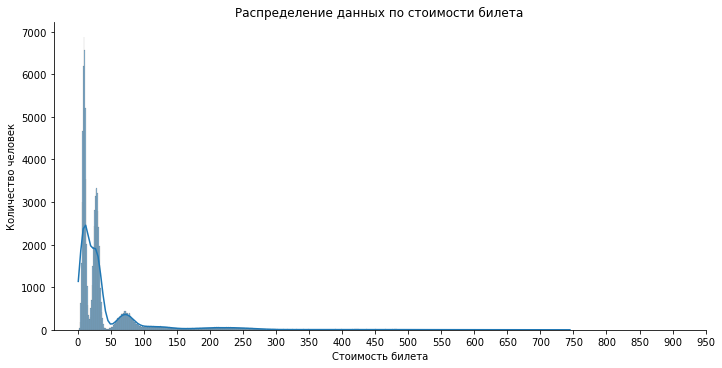

In [65]:
sns.displot(data=df, x='fare', height=5, aspect=2, kde=True)
plt.title('Распределение данных по стоимости билета')
plt.xlabel('Стоимость билета')
plt.ylabel('Количество человек')
plt.xticks(np.arange(0, 1000, 50))
plt.show()

In [66]:
df['ticket_class'].sort_values().unique()

array([1, 2, 3], dtype=int64)

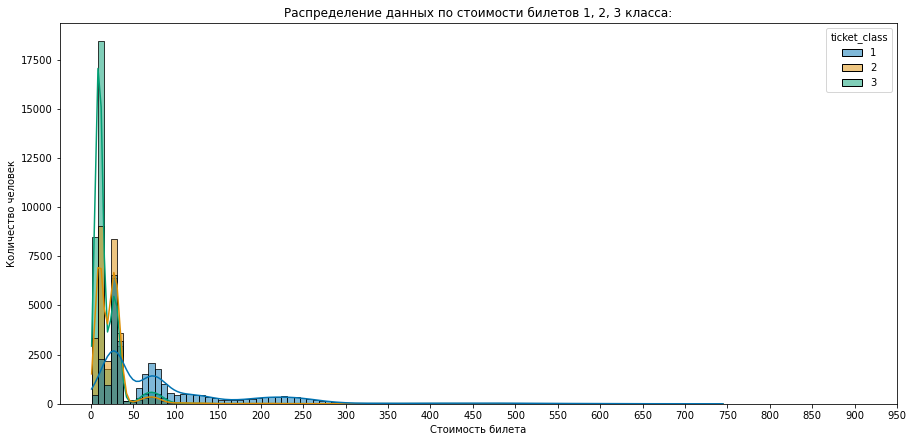

In [67]:
plt.figure(figsize=(15,7))
sns.histplot(data=df, x='fare', hue='ticket_class', bins=100, kde=True, palette='colorblind')
plt.title('Распределение данных по стоимости билетов 1, 2, 3 класса:')
plt.xlabel('Стоимость билета')
plt.ylabel('Количество человек')
plt.xticks(np.arange(0, 1000, 50))
plt.show()

In [68]:
df.groupby(['ticket_class'], as_index=False)['fare'].agg(['describe'])

describe                                                     \
                count       mean        std   min    25%    50%      75%   
ticket_class                                                               
1             30275.0  92.653113  99.821850  3.38  27.89  63.58  116.875   
2             28637.0  25.756003  34.849110  1.72  10.17  22.72   29.210   
3             40954.0  20.618226  32.621763  0.68   8.54  10.96   25.770   

                      
                 max  
ticket_class          
1             744.66  
2             613.43  
3             640.79

что интересно, в каждом классе большую часть билетов занимают очень дешевые билеты при чем даже в 1 классе, но максимальная стоимость билета ожидаемо принадлежит 1 классу, кроме того и по нижней границе билетов, самая высокая она у 1 класса, но в целом такой разброс, когда стандартное отклонение превышает среднее значение, выглядит аномально, возможно внутри есть свои группы по стоимости, которые сильно друг от друг отличаются и вызывают такой разброс значений

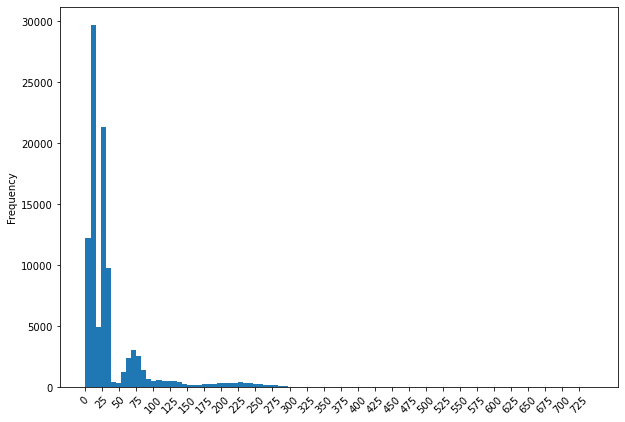

In [69]:
df['fare'].plot(kind='hist', bins=100, figsize=(10,7))
plt.xticks([i for i in range(0, round(df['fare'].max()), 25)], rotation=45)
plt.show()

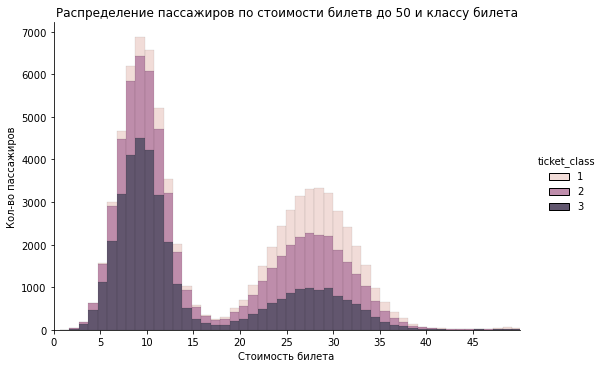

In [70]:
sns.displot(data=df, x='fare', hue='ticket_class', multiple='stack', height=5, aspect=1.5)
plt.title('Распределение пассажиров по стоимости билетв до 50 и классу билета')
plt.xlabel('Стоимость билета')
plt.ylabel('Кол-во пассажиров')
plt.xlim(0, 50)
plt.xticks([i for i in range(0, 50, 5)])
plt.show()

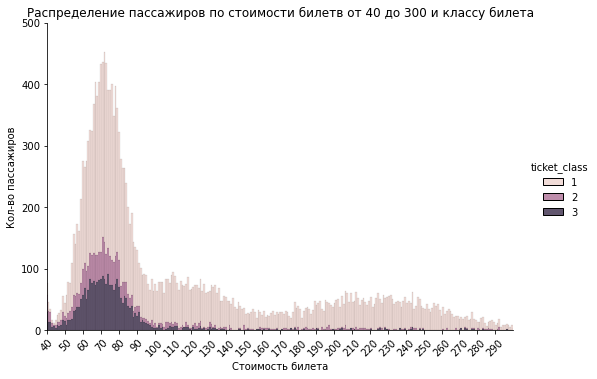

In [71]:
sns.displot(data=df, x='fare', hue='ticket_class', multiple='stack', height=5, aspect=1.5)
plt.title('Распределение пассажиров по стоимости билетв от 40 до 300 и классу билета')
plt.xlabel('Стоимость билета')
plt.ylabel('Кол-во пассажиров')
plt.xlim(40, 300)
plt.ylim(0, 500)
plt.xticks([i for i in range(40, 300, 10)], rotation=45)
plt.show()

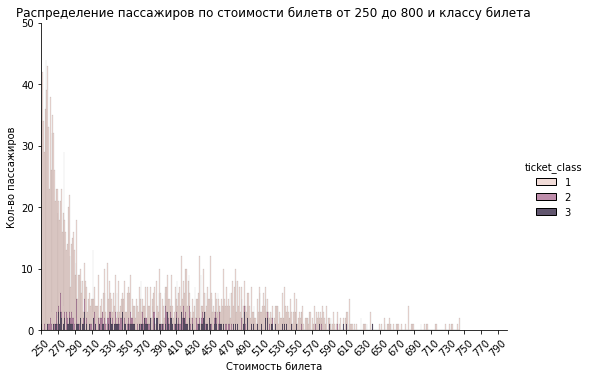

In [72]:
sns.displot(data=df, x='fare', hue='ticket_class', multiple='stack', height=5, aspect=1.5)
plt.title('Распределение пассажиров по стоимости билетв от 250 до 800 и классу билета')
plt.xlabel('Стоимость билета')
plt.ylabel('Кол-во пассажиров')
plt.xlim(250, 800)
plt.ylim(0, 50)
plt.xticks([i for i in range(250, 800, 20)], rotation=45)
plt.show()

отчетливо можно выделить группы по стоимости билетов:
- до 17,5
- от 17,5 до 45
- от 45 до 100
- от 100 до 150
- от 150 до 290
- от 290 до 550
- свыше 550

перед тем, как выделять группы, придется разобраться с пропусками, пожалуй, наиболее справедливо будет заменить их медианами в рамках класса билета и типа каюты

In [73]:
fare_nulls_df = df[df['fare'].isna()].groupby(['ticket_class', 'cabin_type'], as_index=False)['passenger_id'].count()
fare_nulls_df

,ticket_class,cabin_type,passenger_id
0,1,A,4
1,1,B,11
2,1,C,14
3,1,D,5
4,1,E,1
5,1,unknown,5
6,2,C,1
7,2,D,1
8,2,F,1
9,2,unknown,39


In [74]:
mapping_for_na = (
    df
        .groupby(['ticket_class', 'cabin_type'], as_index=False)
            ['fare']
        .median()
        .rename(columns={'fare': 'median_fare'})
)
mapping_for_na

,ticket_class,cabin_type,median_fare
0,1,A,61.450
1,1,B,73.130
2,1,C,77.140
3,1,D,55.760
4,1,E,30.935
5,1,F,29.305
6,1,G,32.000
7,1,T,55.915
8,1,unknown,25.570
9,2,A,29.910


In [75]:
for i in range(fare_nulls_df.shape[0]):
    ticket_class = fare_nulls_df.iloc[i]['ticket_class']
    cabin_type = fare_nulls_df.iloc[i]['cabin_type']
    median_to_fill = (
        mapping_for_na
            .query('ticket_class == @ticket_class \
                    and cabin_type == @cabin_type')
            ['median_fare']
            .item()
    )
    df.loc[(df['fare'].isna())&(df['ticket_class']==ticket_class)&(df['cabin_type']==cabin_type), 'fare'] = median_to_fill

In [76]:
df['fare_group'] = df['fare'].apply(lambda x: '<= 17.5' if x <= 17.5 else\
                                              '17.5 - 45.0' if x <= 45 else\
                                              '45.1 - 100.0' if x <= 100 else\
                                              '100.1 - 150.0' if x <= 150 else\
                                              '150.1 - 290.1' if x <= 290 else\
                                              '290.1 - 550.0' if x <= 550 else\
                                              '> 550.0' if not pd.isnull(x) else\
                                              np.nan)
df.groupby('fare_group', as_index=False, dropna=False)['fare'].agg(['min', 'max', 'mean', 'median', 'std'])

,min,max,mean,median,std
fare_group,,,,,
100.1 - 150.0,100.04,149.95,122.277692,121.320,13.581160
150.1 - 290.1,150.03,289.83,217.409369,217.880,34.638438
17.5 - 45.0,17.51,44.92,28.015935,28.000,4.206905
290.1 - 550.0,290.16,549.93,409.352681,411.320,73.588168
45.1 - 100.0,45.03,100.00,72.700212,72.305,11.106393
<= 17.5,0.68,17.50,9.571408,9.510,2.501835
> 550.0,550.33,744.66,607.419651,590.515,49.805776


среднее и медианы достаточно близко в друг другу расположены, смещение сравнительно малое, границы групп корректны

In [77]:
fare_groups = df.sort_values(by='fare')['fare_group'].dropna().unique()
fare_group_df = pd.DataFrame({
    'fare_group_id': [i for i in range(1, len(fare_groups) + 1)],
    'fare_group': fare_groups
})
print('Mapping table for cabin type:')
display(fare_group_df)

df['fare_group_id'] = 0
for f_group in fare_groups:
    fare_group_id = fare_group_df.query('fare_group == @f_group')['fare_group_id'].item()
    df.loc[df['fare_group']==f_group, 'fare_group_id'] = fare_group_id
print('Check result of mapping:')
display(
    df
        .groupby(['fare_group', 'fare_group_id'], as_index=False, dropna=False)
            ['passenger_id']
        .count()
        .sort_values(by='fare_group_id')
)

Mapping table for cabin type:


,fare_group_id,fare_group
0,1,<= 17.5
1,2,17.5 - 45.0
2,3,45.1 - 100.0
3,4,100.1 - 150.0
4,5,150.1 - 290.1
5,6,290.1 - 550.0
6,7,> 550.0


Check result of mapping:


,fare_group,fare_group_id,passenger_id
5,<= 17.5,1,42667
2,17.5 - 45.0,2,35742
4,45.1 - 100.0,3,11896
0,100.1 - 150.0,4,3232
1,150.1 - 290.1,5,4993
3,290.1 - 550.0,6,1298
6,> 550.0,7,172


### 2.2.12 port_of_embarkation

In [78]:
df['port_of_embarkation'].value_counts(dropna=False)

S      72139
C      22187
Q       5424
NaN      250
Name: port_of_embarkation, dtype: int64

присутствуют пропуски, если бы данные были живые, можно было бы попробовать восстановить порт по принципу семьи, если это была семья, и у них могла быть одна фамилия, но так как данные синтетические, эта информация потеряна, заменим на 'unknown', в остальном аномальных или неверных портов нет

In [79]:
df['port_of_embarkation'] = df['port_of_embarkation'].fillna('unknown')
df['port_of_embarkation'].value_counts(dropna=False)

S          72139
C          22187
Q           5424
unknown      250
Name: port_of_embarkation, dtype: int64

попробуем добавить числовую кодировку, чтобы использовать этот признак при корреляции

In [80]:
df['port_code'] = df['port_of_embarkation'].apply(lambda x: 0 if x == 'S' else \
                                                            1 if x == 'C' else \
                                                            2 if x == 'Q' else \
                                                            3 if x == 'unknown' else \
                                                            4)
(
    df
        .groupby(['port_of_embarkation', 'port_code'], as_index=False)
            ['passenger_id']
        .count()
        .sort_values(by='passenger_id', ascending=False)
)

,port_of_embarkation,port_code,passenger_id
2,S,0,72139
0,C,1,22187
1,Q,2,5424
3,unknown,3,250


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   passenger_id             100000 non-null  int64  
 1   survived                 100000 non-null  int64  
 2   ticket_class             100000 non-null  int64  
 3   passenger_name           100000 non-null  object 
 4   sex                      100000 non-null  int64  
 5   age                      100000 non-null  float64
 6   siblings_spouses_aboard  100000 non-null  int64  
 7   parents_children_aboard  100000 non-null  int64  
 8   ticket_number            100000 non-null  object 
 9   fare                     100000 non-null  float64
 10  cabin_number             100000 non-null  object 
 11  port_of_embarkation      100000 non-null  object 
 12  full_age                 100000 non-null  int64  
 13  age_group                100000 non-null  object 
 14  age_g

пропусков нет, первичный профайлинг данных окончен

# Data exploration

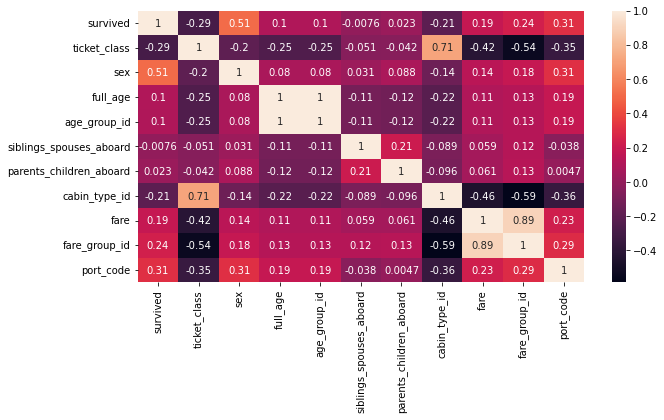

In [82]:
plt.figure(figsize=(10,5))
(
    sns.heatmap(data=df[['survived', 
                         'ticket_class', 
                         'sex',
                         'full_age', 
                         'age_group_id',
                         'siblings_spouses_aboard', 
                         'parents_children_aboard',
                         'cabin_type_id',
                         'fare',
                         'fare_group_id',
                         'port_code']]
                        .corr()
                        .round(4), 
                annot=True)
)
plt.show()

    *на самом деле, корреляции 0,71 в этом датасете нет, она возникла после логической замены пропусков по стоимости билета через связывание с классом билета и типом каюты, возникновение такой связи как итог сказалось на матрице корреляции, к сожалению, другой более-менее адекватной зависимости для восстановления выявить не удалось
**исходная матрица без замены пропусков** выглядела так:
    
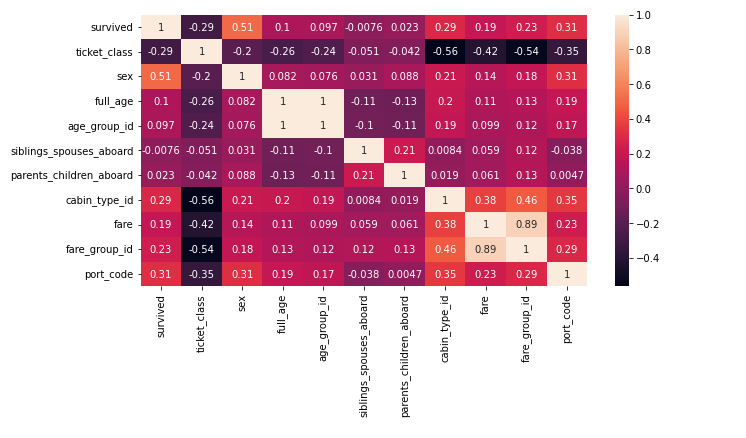

**Survived / Sex**:

In [83]:
temp_df = (
    df
        .groupby(['survived', 'sex'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_of_survived_by_sex'})
        .merge(
                df['survived']
                    .value_counts()
                    .reset_index()
                    .rename(columns={'index': 'survived', 
                                     'survived': 'num_of_survived'}),
                on='survived',
                how='outer'
        )
)
temp_df['servived_pct'] = temp_df['num_of_survived_by_sex'] / temp_df['num_of_survived']
temp_df[['survived', 'sex', 'servived_pct']]

,survived,sex,servived_pct
0,0,0,0.778772
1,0,1,0.221228
2,1,0,0.269977
3,1,1,0.730023


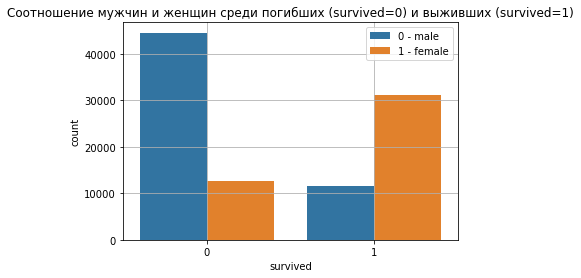

In [84]:
sns.countplot(data=df, x='survived', hue='sex')
plt.title('Соотношение мужчин и женщин среди погибших (survived=0) и выживших (survived=1)')
plt.legend(['0 - male', '1 - female'])
plt.grid(visible=True)
plt.show()

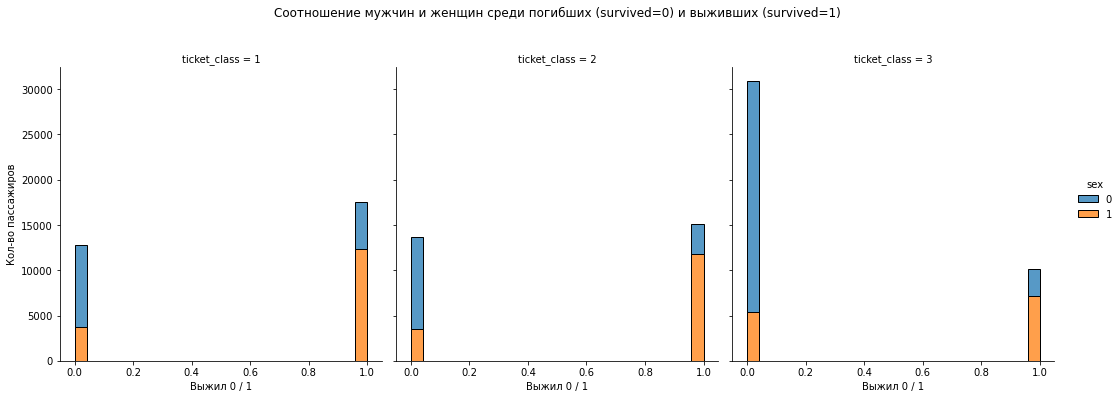

In [85]:
g = sns.displot(data=df, x='survived', hue='sex', col='ticket_class', multiple='stack', palette='tab10')
plt.suptitle('Соотношение мужчин и женщин среди погибших (survived=0) и выживших (survived=1)', x=0.5, y=1.1)
g.set_axis_labels('Выжил 0 / 1','Кол-во пассажиров')
plt.show()

одна из самых сильных корреляций в целом между всеми фичами - с гендером, среди выживших явно больше женщин, возможно это было связно с тем, что в такой ситуации старались спасти более слабых - женщин, жертвуя свое место и в спасательных шлюпках и др.

**Survived / Ticket class**:

также присутствует достаточно сильная зависимоть с классом билета

In [86]:
temp_df = (
    df
        .groupby(['ticket_class', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id':'num_survived_by_class'})
        .merge(df
                   .groupby('ticket_class', as_index=False)
                       ['passenger_id']
                   .count()
                   .rename(columns={'passenger_id':'num_by_class'}),
               on='ticket_class',
               how='outer')
)
temp_df['survived_pct'] = temp_df['num_survived_by_class'] / temp_df['num_by_class']
temp_df[['ticket_class', 'survived', 'survived_pct']]

,ticket_class,survived,survived_pct
0,1,0,0.420221
1,1,1,0.579779
2,2,0,0.474982
3,2,1,0.525018
4,3,0,0.752695
5,3,1,0.247305


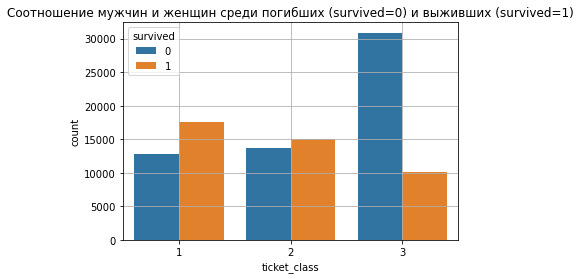

In [87]:
sns.countplot(data=df, x='ticket_class', hue='survived')
plt.title('Соотношение мужчин и женщин среди погибших (survived=0) и выживших (survived=1)')
plt.grid(visible=True)
plt.show()

что интересно, среди пассажиров первого класса самый высокий процент выживших - порядка 58%, среди пассажиров 2 класса 52,5%, из 3 класса спаслось меньше всего пассажиров - 24,7%, что вероятнее всего может быть связано с расположением кают, скорее всего 1 класс находились выше всего, 3 ближе к основанию корабля, и соответственно были быстрее затоплены в том числе за счет неожиданности и вероятнее всего и паники - пассажиров 3 класса было больше всего

In [88]:
temp_df = (
    df
        .groupby(['ticket_class', 'survived', 'sex'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id':'num_survived_by_class'})
        .merge(df
                   .groupby(['ticket_class', 'survived'], as_index=False)
                       ['passenger_id']
                   .count()
                   .rename(columns={'passenger_id':'num_by_class'}),
               on=['ticket_class', 'survived'],
               how='outer')
)
temp_df['survived_pct'] = temp_df['num_survived_by_class'] / temp_df['num_by_class']
temp_df[['ticket_class', 'survived', 'sex', 'survived_pct']]

,ticket_class,survived,sex,survived_pct
0,1,0,0,0.707434
1,1,0,1,0.292566
2,1,1,0,0.296939
3,1,1,1,0.703061
4,2,0,0,0.740860
5,2,0,1,0.259140
6,2,1,0,0.219433
7,2,1,1,0.780567
8,3,0,0,0.824947
9,3,0,1,0.175053


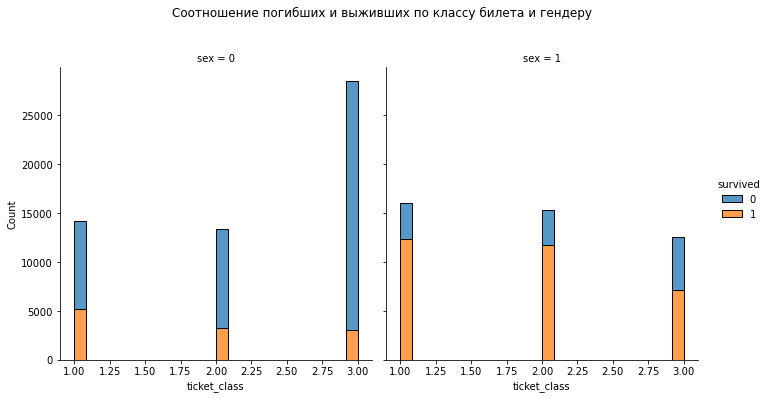

In [89]:
sns.displot(data=df, x='ticket_class', hue='survived', col='sex', multiple='stack')
plt.suptitle('Соотношение погибших и выживших по классу билета и гендеру', x=0.5, y=1.1)
plt.show()

при этом соотношение мужчин и женщин среди выживших для 1 и 3 класса примерно одинаковое, для второго класса немного выше - 78,1%, в среднем это соответствует среднему % выживших по гендеру, полученному на предыдущем шаге

**Survived / Cabin type**:

также присутствует достаточно сильна зависимоть от типа каюты, проверим, что это за каются, к какому классу они относятся, и какое там распределение по гендеру

In [90]:
df.groupby(['cabin_type', 'ticket_class'], as_index=False, dropna=False)['passenger_id'].count()

,cabin_type,ticket_class,passenger_id
0,A,1,5304
1,A,2,627
2,A,3,376
3,B,1,6620
4,B,2,390
5,B,3,429
6,C,1,10694
7,C,2,643
8,C,3,488
9,D,1,2661


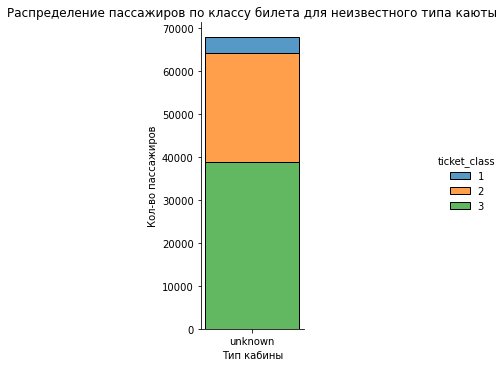

In [91]:
sns.displot(data=df.query('cabin_type == "unknown"').sort_values(by='cabin_type'), 
            x='cabin_type',
            hue='ticket_class', 
            height=5, 
            aspect=0.5, 
            palette='tab10', 
            multiple='stack')
plt.title('Распределение пассажиров по классу билета для неизвестного типа каюты')
plt.xlabel('Тип кабины')
plt.ylabel('Кол-во пассажиров')
plt.show()

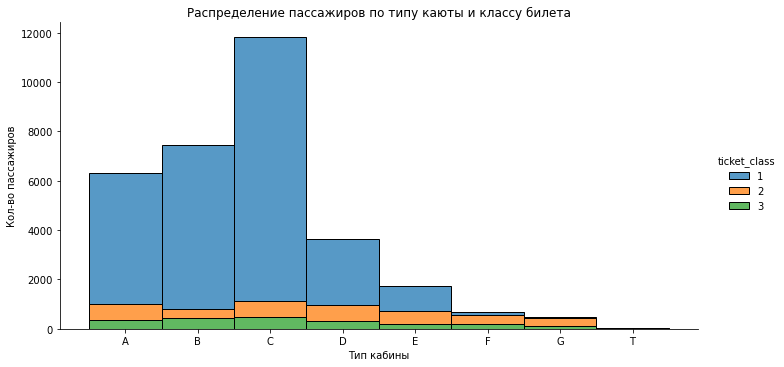

In [92]:
sns.displot(data=df.query('cabin_type != "unknown"').sort_values(by='cabin_type'), 
            x='cabin_type',
            hue='ticket_class', 
            height=5, 
            aspect=2, 
            palette='tab10', 
            multiple='stack')
plt.title('Распределение пассажиров по типу каюты и классу билета')
plt.xlabel('Тип кабины')
plt.ylabel('Кол-во пассажиров')
plt.show()

что интересно, приимущественно билеты 1 класса имеют типы A-C, суть меньше D, E, для остальных классов основная часть билетов имеет тип A-D, но в целом распределение достаточно равномерное, посмотрим на выживших

,cabin_type,survived,passenger_id
0,A,0,4575
1,A,1,1732
2,B,0,2751
3,B,1,4688
4,C,0,3403
5,C,1,8422
6,D,0,974
7,D,1,2663
8,E,0,669
9,E,1,1080


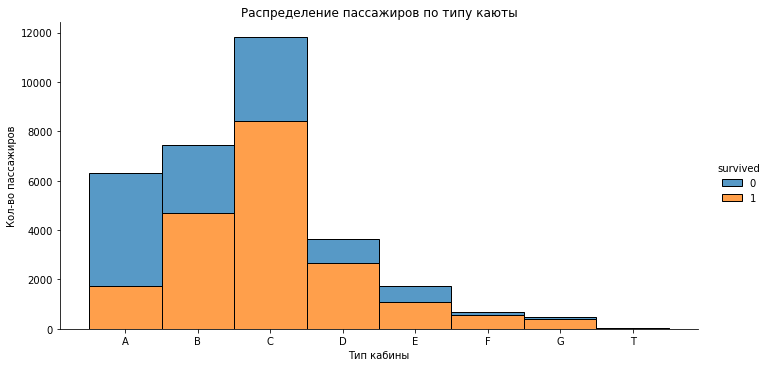

In [93]:
display(df.groupby(['cabin_type', 'survived'], as_index=False)['passenger_id'].count())

sns.displot(data=df.query('cabin_type != "unknown"').sort_values(by='cabin_type'), 
            x='cabin_type',
            hue='survived', 
            height=5, 
            aspect=2, 
            palette='tab10', 
            multiple='stack')
plt.title('Распределение пассажиров по типу каюты')
plt.xlabel('Тип кабины')
plt.ylabel('Кол-во пассажиров')
plt.show()

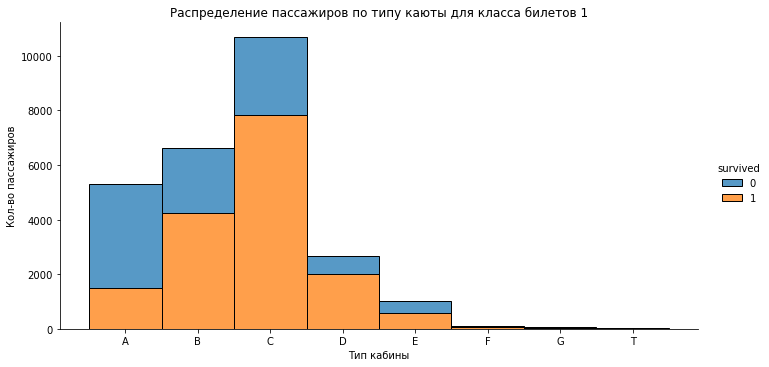

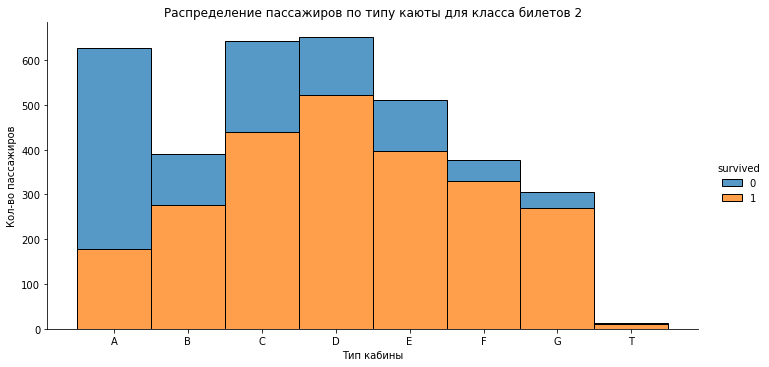

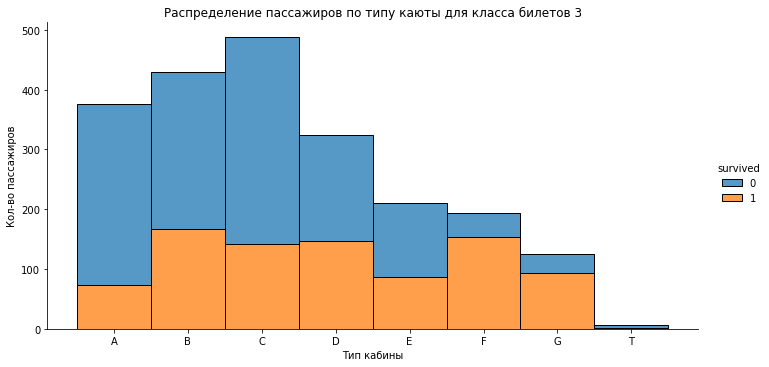

In [94]:
ticket_classes = df['ticket_class'].sort_values().unique()
for tclass in ticket_classes:
    sns.displot(data=df.sort_values(by='cabin_type').query('ticket_class == @tclass and cabin_type != "unknown"'), 
                x='cabin_type',
                hue='survived', 
                height=5, 
                aspect=2, 
                palette='tab10', 
                multiple='stack')
    plt.title(f'Распределение пассажиров по типу каюты для класса билетов {tclass}')
    plt.xlabel('Тип кабины')
    plt.ylabel('Кол-во пассажиров')
    plt.show()

однозачно самым "несчастливым" оказался тип билетов класса A, доля погибших по нему гораздо выше при чем для всех классов билетов (1, 2, 3)

для 1 класса наибольшее кол-во выживших имело билеты типа C и D, для типов B и E шансы выжить были примерно в районе 60-65%

для 2 класса наиболее безопасными оказались типы D-G, B, несколько меньше C

для 3 класса наибольшее число спасшихся имело билеты с типом F,G, все остальные типы к сожалению показывают преобраладание доли погибших, что перекликается с предыдущим анализом параметра класса билета, где в 3 классе было больше всего погибших, похоже, что если каюта находится в нижней части корабля, то не важно какого типа кабина, она затонет первой

в целом, возможно эти типы характеризуют расположение кают на корабле и исходя из удара и повреждений корабля, те или иные каюты оказались более/менее опасными с точки зрения шансов на выживание, в целом признак объективный

**Survived / Port of embarkation**:

также очень сильная корреляция с портом, в котором пассажир зашел на борт, что выглядит достаточно странно, посмотрим подробнее

,port_of_embarkation,survived,passenger_id
0,C,0,5518
1,C,1,16669
2,Q,0,2186
3,Q,1,3238
4,S,0,49394
5,S,1,22745
6,unknown,0,128
7,unknown,1,122


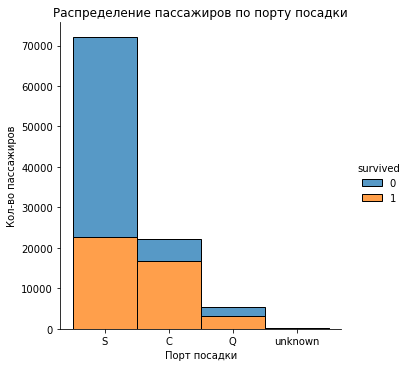

In [95]:
display(
    df
        .groupby(['port_of_embarkation', 'survived'], as_index=False)
            ['passenger_id']
        .count()
)
sns.displot(data=df, x='port_of_embarkation', hue='survived', multiple='stack')
plt.title('Распределение пассажиров по порту посадки')
plt.xlabel('Порт посадки')
plt.ylabel('Кол-во пассажиров')
plt.show()

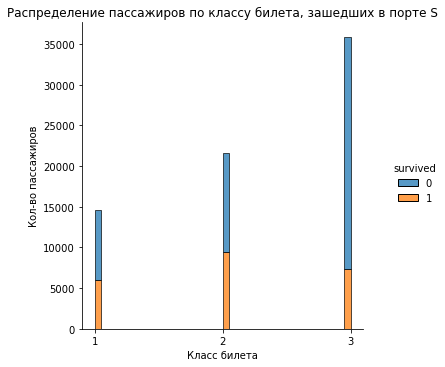

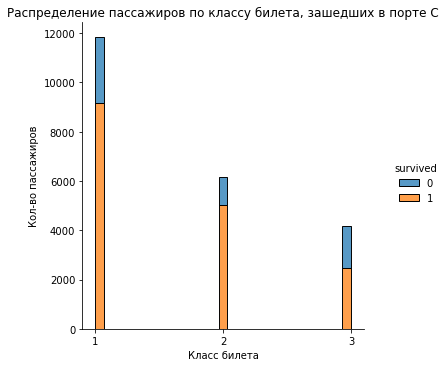

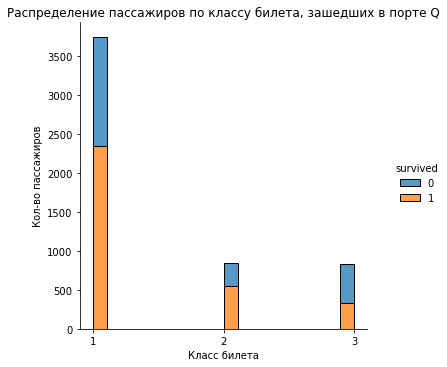

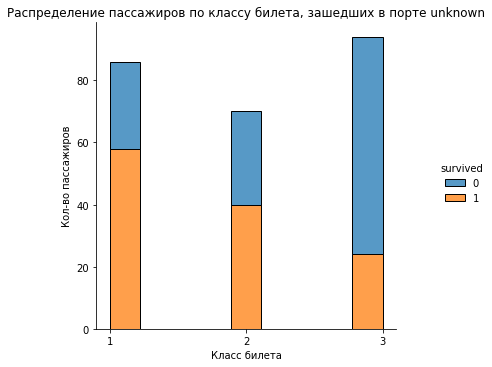

In [96]:
ports_of_embarkation = df['port_of_embarkation'].dropna().unique()
for port in ports_of_embarkation:
    sns.displot(data=df.query('port_of_embarkation == @port'), x='ticket_class', hue='survived', multiple='stack')
    plt.title(f'Распределение пассажиров по классу билета, зашедших в порте {port}')
    plt.xlabel('Класс билета')
    plt.ylabel('Кол-во пассажиров')
    plt.xticks([i for i in range(1, len(ticket_classes)+1)])
    plt.show()

вот и ответ, на самом деле в каждом порту на борт заходили люди с билетами из разных классов, так например в S (Southhampton) большая часть пассажиров имела билеты 3 класса, чуть меньше 2 класса и меньше всего зашло на бор пассажиров 1 класса, при чем доля выживших среди первого класса достаточно низкая, если посмотреть на график ниже, то основная часть билетов приходится на каюты с самым низким процентом выживаемости для 1 класса, поэтому по совокупности этот порт выглядит самым "несчастливым", в реальности это совокупность других факторов

,cabin_type,passenger_id
0,A,3916
1,B,2404
2,C,4056
3,D,792
4,E,479
5,F,50
6,G,22
7,T,7


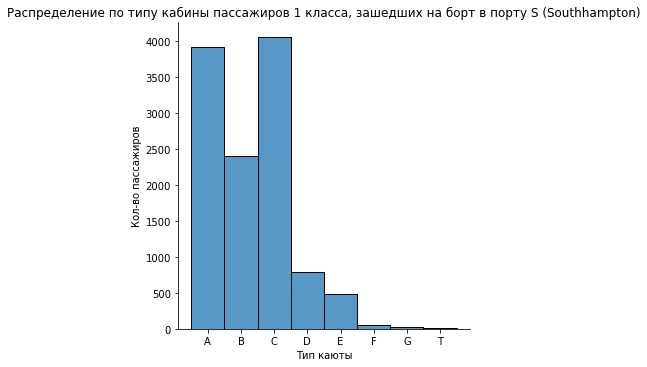

In [97]:
display(
    df
        .query('port_of_embarkation == "S" \
                and ticket_class == 1 \
                and cabin_type != "unknown"')
        .groupby(['cabin_type'], as_index=False)
            ['passenger_id'].count()
)
sns.displot(data=(
                df
                    .query('port_of_embarkation == "S" \
                            and ticket_class == 1 \
                            and cabin_type != "unknown"')
                    .sort_values(by='cabin_type')
            ),
            x='cabin_type')
plt.title('Распределение по типу кабины пассажиров 1 класса, зашедших на борт в порту S (Southhampton)')
plt.xlabel('Тип каюты')
plt.ylabel('Кол-во пассажиров')
plt.show()

**Survived / Fare**:

посмотрим, как стоимость билета связана с выживаемостью

In [98]:
df.groupby(['fare_group', 'survived'], as_index=False, dropna=False)['passenger_id'].count()

,fare_group,survived,passenger_id
0,100.1 - 150.0,0,1101
1,100.1 - 150.0,1,2131
2,150.1 - 290.1,0,1291
3,150.1 - 290.1,1,3702
4,17.5 - 45.0,0,17490
5,17.5 - 45.0,1,18252
6,290.1 - 550.0,0,577
7,290.1 - 550.0,1,721
8,45.1 - 100.0,0,6340
9,45.1 - 100.0,1,5556


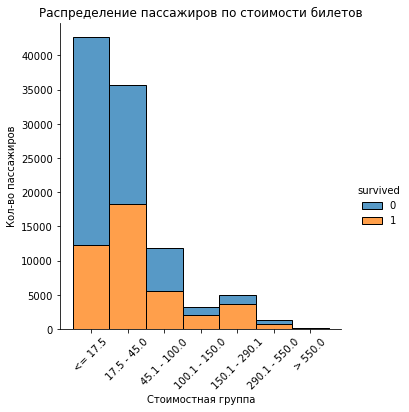

In [99]:
sns.displot(data=df.sort_values(by='fare_group_id'), x='fare_group', hue='survived', multiple='stack', palette='tab10')
plt.title('Распределение пассажиров по стоимости билетов')
plt.xlabel('Стоимостная группа')
plt.ylabel('Кол-во пассажиров')
plt.xticks(rotation=45)
plt.show()

в целом, доля погибших, имевших билеты стоимостью до 17,5 в 2,5 раза превышает количество выживших для этой стоимостной группы

для билетов стоимостью от 17,5 до 100, можно сказать, что доля погибших и выживших примерно одинакова, шансы на спасение были 50/50

начиная от билетов со стоимостью от 100 и выше доля выживших превышает погибших в 2 и более раз

скорее всего это связано с классом билетов, типом кают, возможно в стоимость более дорогих билетов также включались какие-то дополнительные средства безопасности, например жилеты, место в шлюпке и др., посмотрим на эту пропорцию в разрезе классов билетов и типов кают

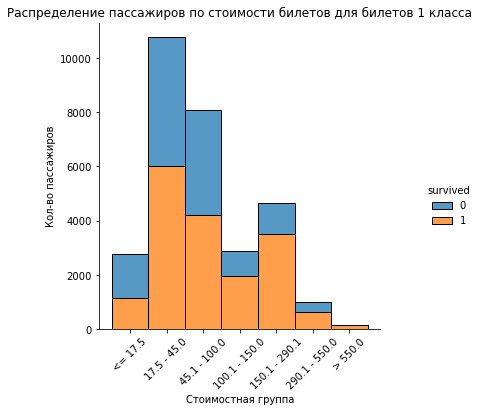

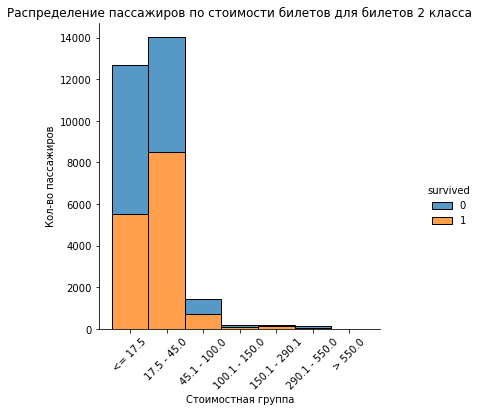

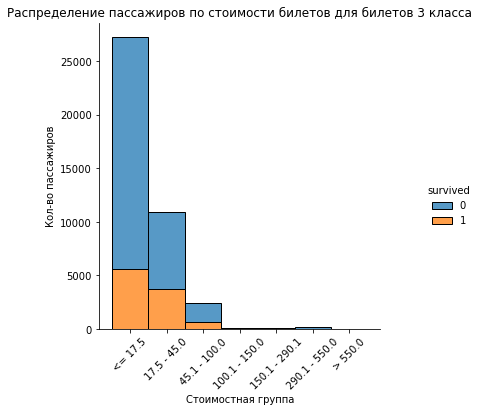

In [100]:
for t_class in ticket_classes:
    sns.displot(data=df.sort_values(by='fare_group_id').query('ticket_class == @t_class'), 
                x='fare_group', 
                hue='survived', 
                multiple='stack', 
                palette='tab10')
    plt.title(f'Распределение пассажиров по стоимости билетов для билетов {t_class} класса')
    plt.xlabel('Стоимостная группа')
    plt.ylabel('Кол-во пассажиров')
    plt.xticks(rotation=45)
    plt.show()

интересен тот факт, что дешевые билеты есть и в 1 классе и во 2 классе, возможно это были места для слуг/сервисного персонала, тем не менее более низкая стоимость билета показывает больший риск гибели при чем в рамках каждого класса билетов, на данный момент признак выглядит достаточно обоснованным

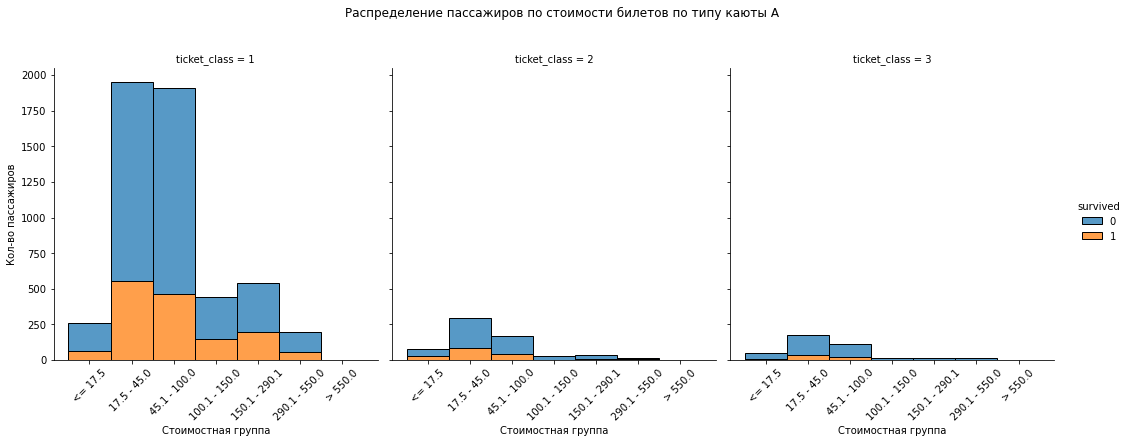

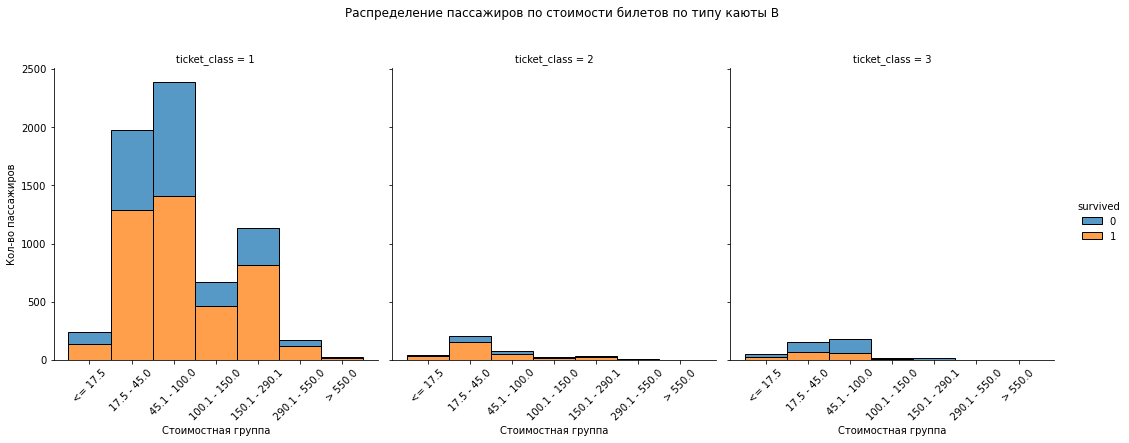

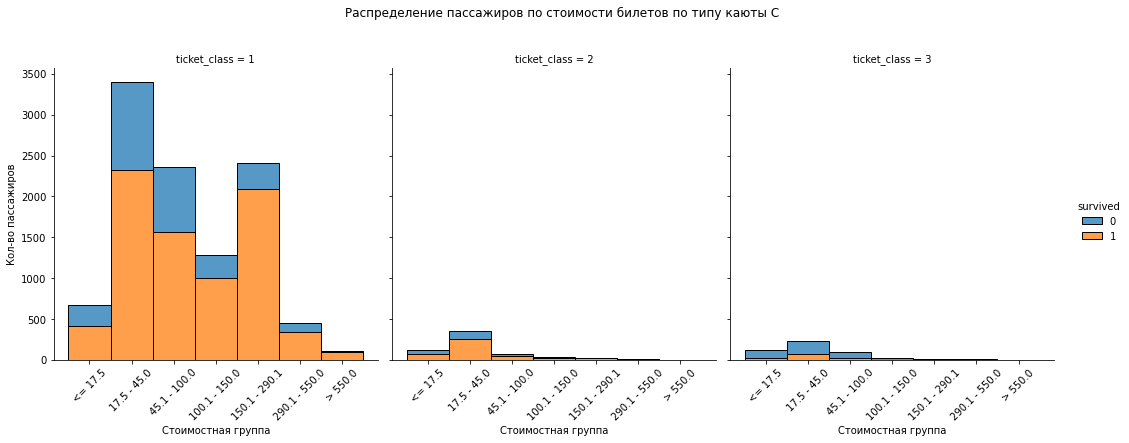

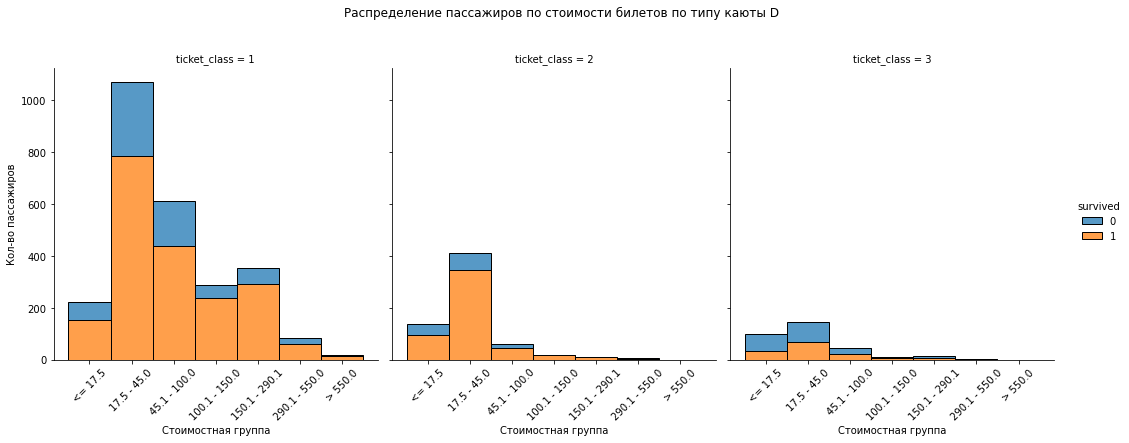

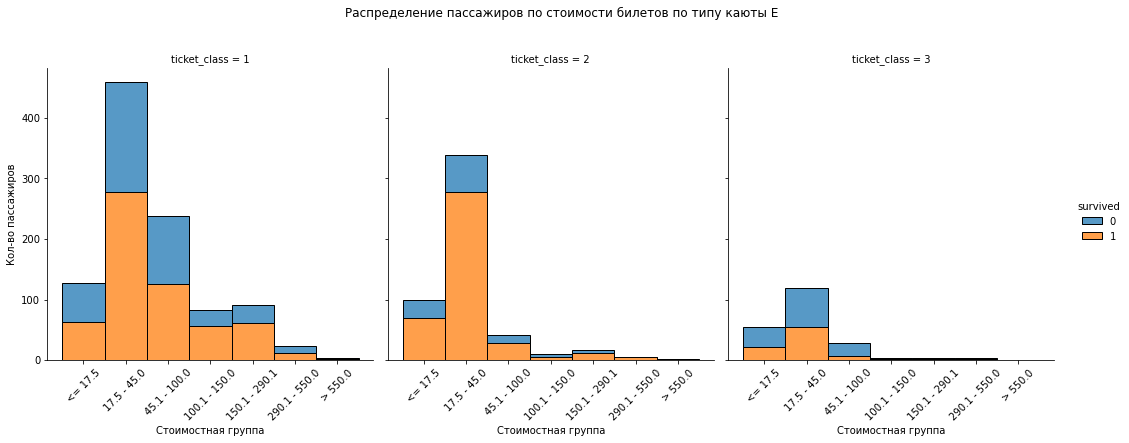

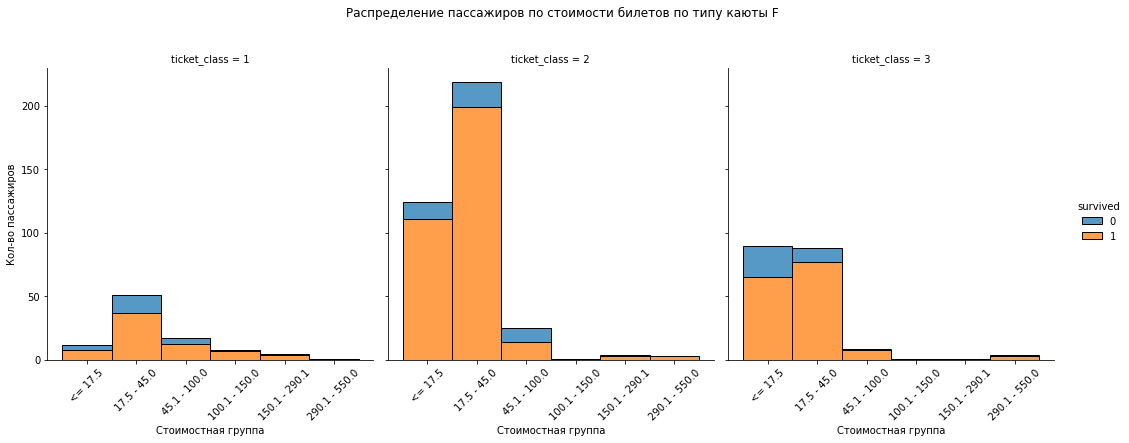

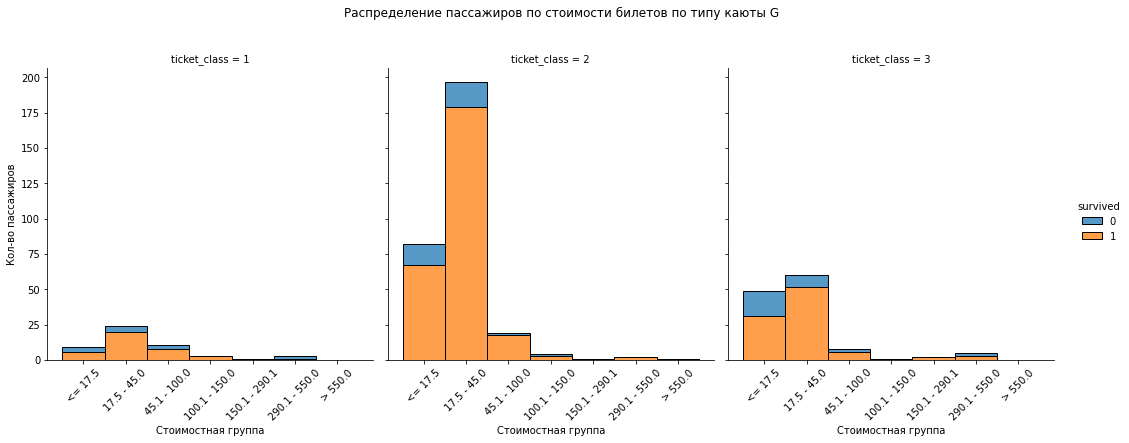

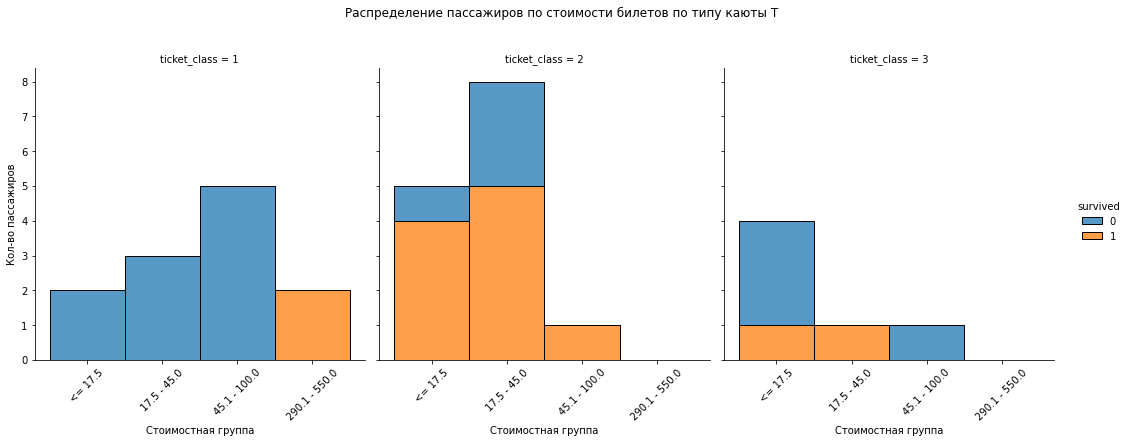

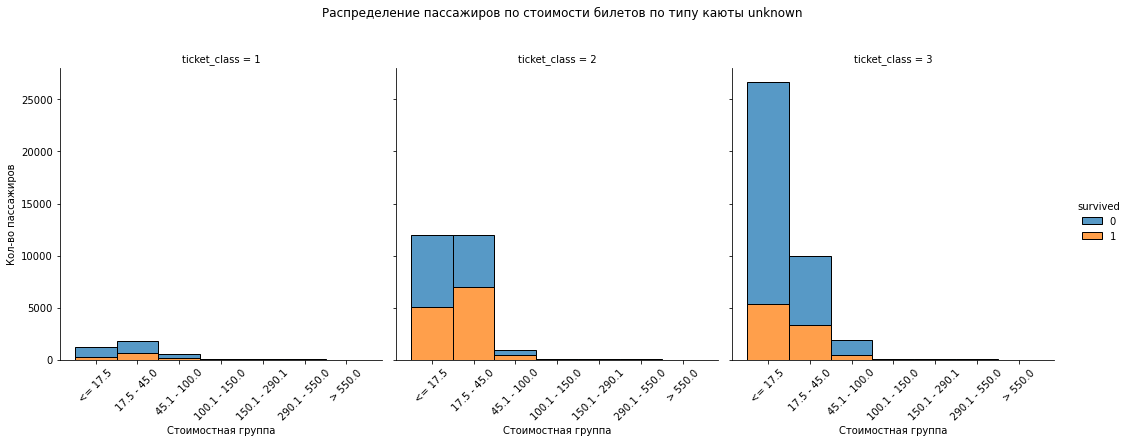

In [101]:
for c_type in unique_cabin_types:
    g = sns.displot(data=df.sort_values(by='fare_group_id').query('cabin_type == @c_type'), 
            x='fare_group',
            col='ticket_class',
            hue='survived', 
            multiple='stack', 
            palette='tab10')
    plt.suptitle(f'Распределение пассажиров по стоимости билетов по типу каюты {c_type}', x=0.5, y=1.1)
    g.set_axis_labels('Стоимостная группа','Кол-во пассажиров')
    g.set_xticklabels(rotation=45)
    plt.show()

в целом можно сказать, что графики выше отчасти описывают уже известную зависимость между выжившими и классом билета, типом каюты, но вместе с тем и добавляют дополнительное различие по стоимостным группам внутри класса билета/типа каюты, таким образом признак объективный, пассажиры с более высокой стоимостью билета в зависимости от его класса и типа каюты имели больше шансов выжить

**Survived / Age**:

посмотрим на зависимость от возраста

In [102]:
temp_df = (
    df
        .sort_values(by='age_group_id')
        .groupby(['age_group', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_age_by_survived'})
        .merge(
            df
             .sort_values(by='age_group_id')
             .groupby(['age_group'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_age'}),
            on ='age_group',
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_age_by_survived'] / temp_df['num_by_age']
temp_df[['age_group', 'survived', 'pct_survived']].query('survived == 1')

,age_group,survived,pct_survived
1,0 - 4,1,0.381276
3,10 - 14,1,0.581437
5,15 - 19,1,0.345178
7,20 - 24,1,0.298619
9,25 - 29,1,0.366292
11,30 - 34,1,0.369554
13,35 - 39,1,0.395543
15,40 - 44,1,0.466380
17,45 - 49,1,0.479917
19,5 - 9,1,0.425357


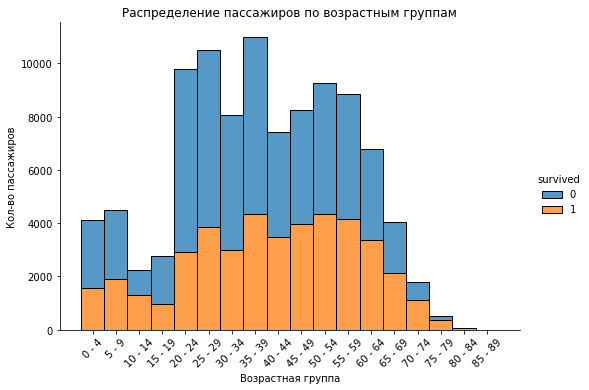

In [103]:
sns.displot(data=df.sort_values(by='age_group_id'), 
            x='age_group', 
            hue='survived', 
            multiple='stack', 
            palette='tab10', 
            height=5, 
            aspect=1.5)
plt.title('Распределение пассажиров по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Кол-во пассажиров')
plt.xticks(rotation=45)
plt.show()

какой-то явной зависимости от возраста не наблюдается, за исключением того, что доля выживших несколько больше среди более возрастных групп и отдельно среди подростков 10-14 лет, посмотрим в разрезе классов билетов

In [104]:
temp_df = (
    df
        .sort_values(by='age_group_id')
        .groupby(['age_group', 'ticket_class','survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_age_by_survived'})
        .merge(
            df
             .sort_values(by='age_group_id')
             .groupby(['age_group', 'ticket_class'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_age'}),
            on =['age_group', 'ticket_class'],
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_age_by_survived'] / temp_df['num_by_age']
for t_class in ticket_classes:
    temp_age_class_df = (
        temp_df[['age_group', 'survived', 'ticket_class', 'pct_survived']]
            .query('ticket_class == @t_class and survived == 1')
    )
    print(f'Доля выживших в рамках {t_class} класса билета')
    display(pd.DataFrame(temp_age_class_df['pct_survived'].describe()).T)
    print(f'Детализация по билетам {t_class} класса:')
    display(temp_age_class_df)

Доля выживших в рамках 1 класса билета


,count,mean,std,min,25%,50%,75%,max
pct_survived,17.0,0.55985,0.06476,0.421384,0.532808,0.581581,0.598245,0.658349


Детализация по билетам 1 класса:


,age_group,survived,ticket_class,pct_survived
1,0 - 4,1,1,0.421384
7,10 - 14,1,1,0.555556
13,15 - 19,1,1,0.485640
19,20 - 24,1,1,0.480836
25,25 - 29,1,1,0.532808
31,30 - 34,1,1,0.544386
37,35 - 39,1,1,0.581581
43,40 - 44,1,1,0.593417
49,45 - 49,1,1,0.598245
55,5 - 9,1,1,0.458848


Доля выживших в рамках 2 класса билета


,count,mean,std,min,25%,50%,75%,max
pct_survived,18.0,0.600942,0.156743,0.431138,0.518573,0.544537,0.666122,1.0


Детализация по билетам 2 класса:


,age_group,survived,ticket_class,pct_survived
3,0 - 4,1,2,0.564682
9,10 - 14,1,2,0.684859
15,15 - 19,1,2,0.517473
21,20 - 24,1,2,0.431138
27,25 - 29,1,2,0.489955
33,30 - 34,1,2,0.450158
39,35 - 39,1,2,0.456876
45,40 - 44,1,2,0.521872
51,45 - 49,1,2,0.557531
57,5 - 9,1,2,0.531543


Доля выживших в рамках 3 класса билета


,count,mean,std,min,25%,50%,75%,max
pct_survived,18.0,0.345461,0.198948,0.187013,0.233855,0.258992,0.409617,1.0


Детализация по билетам 3 класса:


,age_group,survived,ticket_class,pct_survived
5,0 - 4,1,3,0.313670
11,10 - 14,1,3,0.463059
17,15 - 19,1,3,0.233599
23,20 - 24,1,3,0.196915
29,25 - 29,1,3,0.239623
35,30 - 34,1,3,0.189929
41,35 - 39,1,3,0.187013
47,40 - 44,1,3,0.240789
53,45 - 49,1,3,0.234623
59,5 - 9,1,3,0.347772


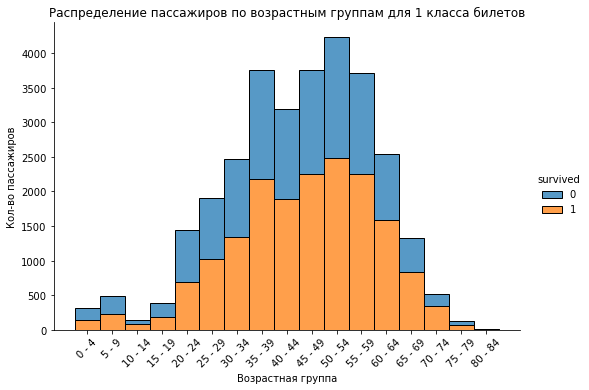

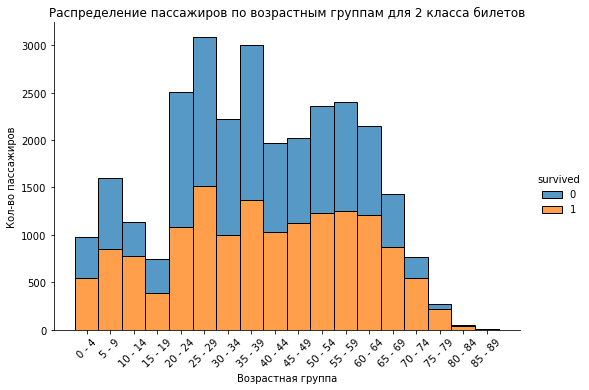

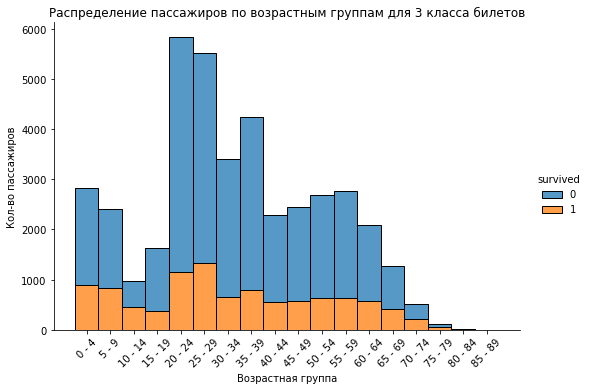

In [105]:
for t_class in ticket_classes:
    sns.displot(data=df.query('ticket_class == @t_class').sort_values(by='age_group_id'), 
                x='age_group', 
                hue='survived', 
                multiple='stack', 
                palette='tab10', 
                height=5, 
                aspect=1.5)
    plt.title(f'Распределение пассажиров по возрастным группам для {t_class} класса билетов')
    plt.xlabel('Возрастная группа')
    plt.ylabel('Кол-во пассажиров')
    plt.xticks(rotation=45)
    plt.show()

на текущий момент выживаемость скорее зависит от класса билета, хотя сложно не заметить, что более возрастные пассажиры имеют больше шансов выжить, посмотрим на то как распределены люди по возрасту в рамках каждого класса

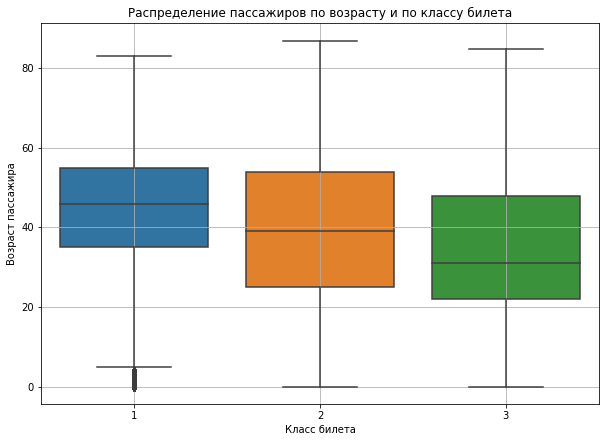

In [106]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df, x='ticket_class', y='full_age')
plt.title('Распределение пассажиров по возрасту и по классу билета')
plt.xlabel('Класс билета')
plt.ylabel('Возраст пассажира')
plt.grid(visible=True)
plt.show()

пассажиры 1 класса зачастую были более возрастными, средний возраст здесь выше, чем в дургих классах, а разброс значений меньше, чем в других классах, во втором классе путешествовали люди несколько моложе, и в третьем классе средний возраст меньше всего, 

в целом ожидаемо, если учесть, что выживаемость 1 класса выше и средний возраст этих людей выше, ожидаемо можно предположить, что возраст влияет на выживаемость, но на самом деле это скорее возрастной состав конкретных групп пассажиров, а выживаемость зависит от других факторов и возраст на нее не сильно влияет

**Survived / Siblings_spouses_aboard**

In [107]:
df.groupby(['siblings_spouses_aboard', 'survived'], as_index=False)['passenger_id'].count()

,siblings_spouses_aboard,survived,passenger_id
0,0,0,42017
1,0,1,31291
2,1,0,11188
3,1,1,8570
4,2,0,2022
5,2,1,1681
6,3,0,981
7,3,1,654
8,4,0,729
9,4,1,439


In [108]:
temp_df = (
    df
        .sort_values(by='siblings_spouses_aboard')
        .groupby(['siblings_spouses_aboard', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_sib_by_survived'})
        .merge(
            df
             .sort_values(by='siblings_spouses_aboard')
             .groupby(['siblings_spouses_aboard'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_sib'}),
            on ='siblings_spouses_aboard',
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_sib_by_survived'] / temp_df['num_by_sib']
temp_df[['siblings_spouses_aboard', 'survived', 'pct_survived']]

,siblings_spouses_aboard,survived,pct_survived
0,0,0,0.573157
1,0,1,0.426843
2,1,0,0.566252
3,1,1,0.433748
4,2,0,0.546044
5,2,1,0.453956
6,3,0,0.600000
7,3,1,0.400000
8,4,0,0.624144
9,4,1,0.375856


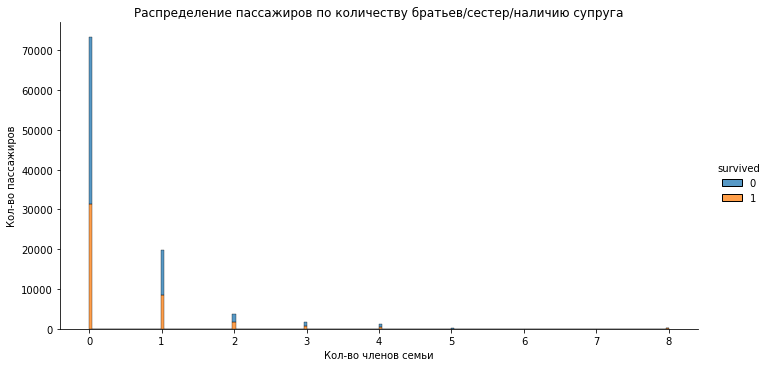

In [109]:
sns.displot(data=df, x='siblings_spouses_aboard', hue='survived', multiple='stack', height=5, aspect=2)
plt.title('Распределение пассажиров по количеству братьев/сестер/наличию супруга')
plt.xlabel('Кол-во членов семьи')
plt.ylabel('Кол-во пассажиров')
plt.show()

что интересно, наличие родственников до 3 человек практически не влияет на выживаемость, а с 3 и более напротив снижает шансы выжить, чтобы убедиться, что это реальный признак, проверим класс билетов

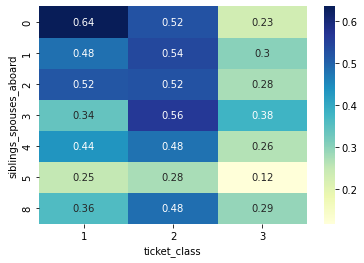

In [110]:
temp_df = (
    df
        .sort_values(by='siblings_spouses_aboard')
        .groupby(['siblings_spouses_aboard', 'ticket_class', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_sib_by_survived'})
        .merge(
            df
             .sort_values(by='siblings_spouses_aboard')
             .groupby(['siblings_spouses_aboard', 'ticket_class'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_sib'}),
            on =['siblings_spouses_aboard', 'ticket_class'],
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_sib_by_survived'] / temp_df['num_by_sib']
sns.heatmap(
    temp_df[['siblings_spouses_aboard', 'ticket_class', 'survived', 'pct_survived']]
        .query('survived == 1')
        .drop(columns='survived')
        .sort_values(by=['siblings_spouses_aboard', 'ticket_class'])
        .pivot(index='siblings_spouses_aboard', columns='ticket_class', values='pct_survived'),
    cmap='YlGnBu',
    annot=True

)
plt.show()

несмотря на то, что наибольшая выживаемость имеет место быть в 1 кассе у людей, не имеющих родственников, тем не менее в том числе и в других классах не редки случаи высокой выживаемости людей и 2-4 родственниками на борту, при чем аномально низкая выживаемость у людей с 5 родственниками, и затем она резко возрастает для людей с 8 родственниками на борту, что не имеет логического смысла, поэтом пожалуй, признак не притический и вероятнее всего данное распределение выживаемости обусловлено другими факторами или их совокупностью

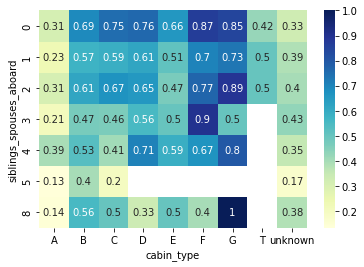

In [111]:
temp_df = (
    df
        .sort_values(by='siblings_spouses_aboard')
        .groupby(['siblings_spouses_aboard', 'cabin_type', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_sib_by_survived'})
        .merge(
            df
             .sort_values(by='siblings_spouses_aboard')
             .groupby(['siblings_spouses_aboard', 'cabin_type'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_sib'}),
            on =['siblings_spouses_aboard', 'cabin_type'],
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_sib_by_survived'] / temp_df['num_by_sib']
sns.heatmap(
    temp_df[['siblings_spouses_aboard', 'cabin_type', 'survived', 'pct_survived']]
        .query('survived == 1')
        .drop(columns='survived')
        .sort_values(by=['siblings_spouses_aboard', 'cabin_type'])
        .pivot(index='siblings_spouses_aboard', columns='cabin_type', values='pct_survived'),
    cmap='YlGnBu',
    annot=True

)
plt.show()

аналогичные колебания выживаемости, если смотреть в разрезе типов кают, на основании этих данных также можно говорить, что этот признак не определяющий для выживаемости

**Survived / Parents and children aboard**

In [112]:
df.groupby(['parents_children_aboard', 'survived'], as_index=False)['passenger_id'].count()

,parents_children_aboard,survived,passenger_id
0,0,0,43741
1,0,1,29799
2,1,0,5302
3,1,1,7694
4,2,0,6913
5,2,1,4323
6,3,0,499
7,3,1,484
8,4,0,319
9,4,1,127


In [113]:
temp_df = (
    df
        .sort_values(by='parents_children_aboard')
        .groupby(['parents_children_aboard', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_parch_by_survived'})
        .merge(
            df
             .sort_values(by='parents_children_aboard')
             .groupby(['parents_children_aboard'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_parch'}),
            on ='parents_children_aboard',
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_parch_by_survived'] / temp_df['num_by_parch']
temp_df[['parents_children_aboard', 'survived', 'pct_survived']].query('survived == 1')

,parents_children_aboard,survived,pct_survived
1,0,1,0.405208
3,1,1,0.592028
5,2,1,0.384745
7,3,1,0.492370
9,4,1,0.284753
11,5,1,0.570997
13,6,1,0.205882
15,9,1,0.439394


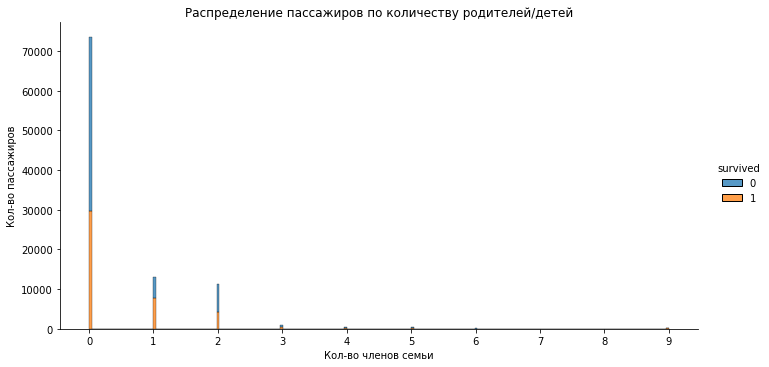

In [114]:
sns.displot(data=df, x='parents_children_aboard', hue='survived', multiple='stack', height=5, aspect=2)
plt.title('Распределение пассажиров по количеству родителей/детей')
plt.xlabel('Кол-во членов семьи')
plt.ylabel('Кол-во пассажиров')
plt.xticks([i for i in range(df['parents_children_aboard'].max() + 1)])
plt.show()

аналогично братьяс/сестрам/супругам ситуация с родителями/детьми также достаточно неоднозначная, присутствует достаточно высокий % выживших с 1 родителем/ребенком, но кроме этого аналогичный % выживаемости у людей с 5 членами семьи (родитель/ребенок), что немного алогично, посмотрим подробнее по классам билетов и типам кают

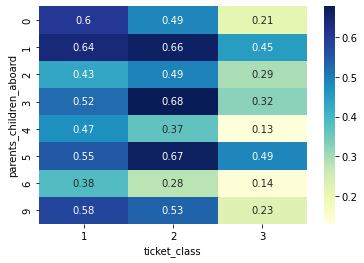

In [115]:
temp_df = (
    df
        .sort_values(by='parents_children_aboard')
        .groupby(['parents_children_aboard', 'ticket_class', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_parch_by_survived'})
        .merge(
            df
             .sort_values(by='parents_children_aboard')
             .groupby(['parents_children_aboard', 'ticket_class'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_parch'}),
            on =['parents_children_aboard', 'ticket_class'],
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_parch_by_survived'] / temp_df['num_by_parch']
sns.heatmap(
    temp_df[['parents_children_aboard', 'ticket_class', 'survived', 'pct_survived']]
        .query('survived == 1')
        .drop(columns='survived')
        .sort_values(by=['parents_children_aboard', 'ticket_class'])
        .pivot(index='parents_children_aboard', columns='ticket_class', values='pct_survived'),
    cmap='YlGnBu',
    annot=True

)
plt.show()

аналогичная ситуация, зависимости не наблюдается

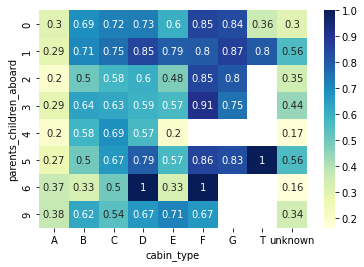

In [116]:
temp_df = (
    df
        .sort_values(by='parents_children_aboard')
        .groupby(['parents_children_aboard', 'cabin_type', 'survived'], as_index=False)
            ['passenger_id']
        .count()
        .rename(columns={'passenger_id': 'num_by_parch_by_survived'})
        .merge(
            df
             .sort_values(by='parents_children_aboard')
             .groupby(['parents_children_aboard', 'cabin_type'], as_index=False)
                 ['passenger_id']
             .count()
             .rename(columns={'passenger_id': 'num_by_parch'}),
            on =['parents_children_aboard', 'cabin_type'],
            how='outer'
        )
)
temp_df['pct_survived'] = temp_df['num_by_parch_by_survived'] / temp_df['num_by_parch']
sns.heatmap(
    temp_df[['parents_children_aboard', 'cabin_type', 'survived', 'pct_survived']]
        .query('survived == 1')
        .drop(columns='survived')
        .sort_values(by=['parents_children_aboard', 'cabin_type'])
        .pivot(index='parents_children_aboard', columns='cabin_type', values='pct_survived'),
    cmap='YlGnBu',
    annot=True

)
plt.show()

аналогичная ситуация, зависимости нет, крайне высокие значения для типов F-T скорее обусловлены малой выборкой по этим типам и не могут говорить наверняка о наличии зависимости

# Summary

Таким образом, пожалуй, основными признаками, влияющими на выживаемость пассажиров на Титанике оказался класс билета (1, 2, 3), так пассажиры 1 и 2 класса однозначно имели больше шансов на выживание,

также сыграло свою роль и расположение кают, их тип, в виду того, что Титаник затонул из-за столкновения с айсбергом, расположение тоже стало решающим фактором в вопросе выживания

кроме того одним из важных факторов оказался гендер, так вреди выживших значительно больше женщин, при чем для билетов всех классов

что интересно, присутствуют условно "ложные" признаки, например такие как порт посадки, что на самомо деле объясняется структурой пассажиров по классу билета и типу каюты, которые заходили на борт на той или иной остановке, а сам признак не играет решающую роль

кроме того присутствуют признаки, которые не оказывают влияния на выживаемость, имеют достаточно разбросанные значения и не позволяют говорить о какой-то зависимости, как например, кол-во/наличие братьев/сестер/супруга/супруги или кол-во/наличие родителей/детей